# WQD7003 : DATA ANALYTICS (Group Project)

## Flight Ticket Price Prediction

## Group 7


JOER YEOH (22077700)

MUHAMMAD SYAHIRUL KHALIQ BIN MOHAMED AIDI SHAHRIZ (22075208)

SAIDATUL HANIDA BINTI MOHD YUKHI (22082961)

VINOD KUNHI KRISHNAN ANNUKARAN (22079942)

IZZAH ATHIRAH BINTI MOHAMAD RADZI (S2179297)

# 1. Introduction

## 1.1 Project Background

The objective of the study is to analyse the flight booking dataset obtained from “Ease My Trip” website published in Kaggle and to conduct various statistical hypothesis tests in order to get meaningful information from it. Various statistical algorithm would be used to train the dataset and predict a continuous target variable.

'Easemytrip' is an internet platform for booking flight tickets, and hence a platform that potential passengers use to buy tickets. A thorough study of the data will aid in the discovery of valuable insights that will be of enormous value to passengers.

## 1.2 Problem Statement

It’s really not easy to guess the price of a flight ticket. The price changes every hour/day/week/month and one person could get more expensive ticket now compared to other person buying the same ticket at a later time, and vice versa.

To better understand how to actually estimate the price of a flight ticket, we have studied a dataset from the “EaseMyTrip” website that shows the booking history of passengers who travelled between India’s top six metro cities from February 11th to March 31st, 2022.


## 1.3 Project Objective

To analyze the flight booking dataset obtained from “EaseMyTrip” website to discover valuable insights that will be of great help to the passengers to get best ticket prices

# 2. Data Understanding

In this phase, the following steps were taken:
- **Initial Data Collection:** The dataset was downloaded from Kaggle Datasets. The dataset we have acquired comes in two parts, namely flights for economy class and business class. Here, we can load both parts of the dataset into two Pandas data frames by parsing the comma-separated values files.
- **Data Description**: A data dictionary providing detailed information about the variables and their attributes is constructed. It serves as a reference guide, enhancing data understanding and facilitating effective data management by disseminating essential metadata.
- **Data Quality Verification**: Identify missing values and assess opportunities for deriving new columns or removing irrelevant columns.

## 2.1 Initial Data Collection

The original dataset for the subsequent analyses originates from Kaggle Datasets. It is secondary data created from the EaseMyTrip website, an Indian online travel company based in Delhi. Specifically, the author used the Octoparse scraping tool to extract the data from the raw HTML strings. In addition, the dataset comes in two parts: one for economy class tickets and another for business class tickets. Both parts total 300,261 distinct flight booking options over 50 days, from February 11th to March 31st, 2022. The counts of flights are 206,774 and 93,487 for economy and business class, respectively.

The characteristics of the dataset are summarized below:
- Contains 300,000+ flight booking options from EaseMyTrip.
- In two parts: one for economy class tickets and another for business class tickets.
- Obtained from Kaggle Datasets.

## 2.2 Importing Libraries

The codes below are used to import various libraries and modules that will be used for our analysis.

1. `import json`: To provide functions for working with JSON data.

2. `import re`: To provide regular expression matching operations.

3. `from catboost import CatBoostRegressor`: a gradient boosting algorithm that is known for its ability to handle categorical features efficiently.

4. `from hyperopt import hp, STATUS_OK, Trials, fmin, tpe`: hyperopt` is a library for hyperparameter optimization. The imported elements include:
   - `hp`: To define search spaces for hyperparameters.
   - `STATUS_OK`: Status of a successful evaluation in hyperopt.
   - `Trials`: Keeps track of the hyperparameter optimization trials.
   - `fmin`: To minimize an objective function using a specified search algorithm.
   - `tpe`: a tree-structured Parzen estimator (TPE) algorithm, which is one of the search algorithms available in hyperopt.

5. `from lightgbm import log_evaluation, LGBMRegressor`: a gradient boosting algorithm that is known for its efficiency and speed. The imported elements include:
   - `log_evaluation`: To customize the logging during training of LightGBM models.
   - `LGBMRegressor`: Represents the LightGBM regressor, which is used for regression tasks.

6. `import matplotlib.pyplot as plt`: To provide a MATLAB-like interface for creating visualizations.

7. `import numpy as np`: To provide support for large, multi-dimensional arrays and mathematical functions.

8. `import pandas as pd`: To provide data structures and functions for efficiently working with structured data, such as tabular data.

9. `import seaborn as sns`: To provide a high-level interface for creating visualization

10. `from sklearn.ensemble import RandomForestRegressor`: an ensemble machine learning model based on decision trees, used for regression tasks.

11. `from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor`: multiple linear regression models

12. `from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score`: various evaluation metrics commonly used for evaluating regression models.

13. `from sklearn.model_selection import train_test_split`: To split a dataset into training and testing subsets for model evaluation.

14. `from sklearn.neighbors import KNeighborsRegressor`: a machine learning model that uses the k-nearest neighbors algorithm for regression tasks.

15. `from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler`: used for encoding categorical variables and scaling numerical features.

16. `from sklearn.svm import LinearSVR`: a support vector machine (SVM) algorithm for regression tasks.

17. `from sklearn.tree import DecisionTreeRegressor`: a decision tree algorithm used for regression tasks.

18. `from tensorflow import keras`: a high-level neural networks API that can run on top of various deep learning frameworks, including `TensorFlow`.

19. `from tensorflow.keras.callbacks import EarlyStopping`: To stop training a neural network model early based on certain conditions, such as no improvement in the validation loss.

20. `from tensorflow.keras.layers import Dense, Dropout, Input`:`Dense` represents a fully connected layer, `Dropout` represents a regularization technique that randomly drops out a fraction of input units during training, and `Input` represents the input layer.

21. `from tensorflow.keras.models import Sequential`: a linear stack of neural network layers.

22. `from tensorflow.keras.optimizers import Adam`: an optimization algorithm commonly used for training neural networks.

23. `from xgboost import XGBRegressor, plot_importance`: `XGBRegressor` is an implementation of the gradient boosting algorithm for regression tasks, and `plot_importance` is a function used to plot feature importances in XGBoost models.

24. `%matplotlib inline`: This is a magic command used in Jupyter notebooks or iPython environments to display matplotlib plots directly in the notebook.

25. `%config InlineBackend.figure_formats = ['retina']`: This sets the configuration for the figure formats in the notebook, specifying that the 'retina' format should be used for better quality plots on high-resolution displays.


In [ ]:
import json
import re

from catboost import CatBoostRegressor
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from joblib import dump, load
from lightgbm import log_evaluation, LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor, plot_importance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

## 2.3 Data Loading

As the dataset comes in two CSV files, we read the contents and loaded them into two separate data frames, namely, `df_eco` and `df_biz`.

In [ ]:
df_eco = pd.read_csv("dataset/economy.csv", thousands=',')
df_biz = pd.read_csv("dataset/business.csv", thousands=',')

Then, we displayed the top few rows of the data frames to inspect the structure and content of the data, including column names and a preview of data values, allowing us to glimpse the data and assess its quality, format, and initial patterns.

In [ ]:
df_eco_disp = df_eco.copy()
df_biz_disp = df_biz.copy()
df_eco_disp.stop = df_eco_disp.stop.str.slice(0, 8)
df_biz_disp.stop = df_biz_disp.stop.str.slice(0, 8)

pd.concat((df_eco.head(), df_biz_disp.head()))

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,25612
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,25612
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t,20:45,Mumbai,42220
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t,23:55,Mumbai,44450
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t,23:55,Mumbai,46690


## 2.4 Data Description

There are 11 columns in this flight ticket price prediction dataset, which includes airlines, source city, departure and arrival time, destination, etc. The various features of the raw dataset are explained below:

- `date`: The booking date consists of the day, month, and year components, providing a complete representation of when the booking was made.
- `airline`: The airline column in the dataset contains the names of airline companies. This categorical feature encompasses a total of six different airlines.
- `ch_code`: The "ch_code" represents a character-based flight code, typically consisting of alphabetic characters. This code may include letters corresponding to the airline, airport, or specific flight route.
- `num_code`: The "num_code" refers to a numerical flight code, typically composed of numeric digits. This code is usually assigned sequentially or based on certain conventions and may not carry any specific meaning. It is commonly used for internal tracking or system purposes.
- `dep_time`: The departure time represents when an aircraft is expected to take off and begin its journey to the destination. Departure time is typically specified using a 24-hour clock format, indicating hours and minutes.
- `from`: The departure city refers to the specific city from which a flight originates or takes off. It is a categorical feature with six unique cities.
- `time_taken`: A continuous feature that represents the total time taken to travel between cities, expressed in hours and minutes.
- `stop`: A categorical feature with three unique values representing the number of stops between the source and destination cities.
- `arr_time`: Arrival time refers to the specific time at which a flight is scheduled to arrive at its destination airport. It indicates the estimated time of arrival (ETA) when the aircraft is expected to land and complete its journey. Arrival time is typically specified using a 24-hour clock format, indicating hours and minutes.
- `to`: The arrival city refers to the specific city where a flight is scheduled to land or arrive. It is a categorical feature with six unique cities.
- `price`: The target variable contains information about the ticket price. It serves as the dependent variable or the outcome variable that is being predicted or analyzed in a machine learning or statistical model.


## 2.5 Data Quality Verification

The summary of the data frame displays useful information such as the number of rows and columns, the data types of each column, the count of non-null values, and memory usage.

In [ ]:
df_eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        206774 non-null  object
 1   airline     206774 non-null  object
 2   ch_code     206774 non-null  object
 3   num_code    206774 non-null  int64 
 4   dep_time    206774 non-null  object
 5   from        206774 non-null  object
 6   time_taken  206774 non-null  object
 7   stop        206774 non-null  object
 8   arr_time    206774 non-null  object
 9   to          206774 non-null  object
 10  price       206774 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 17.4+ MB


In [ ]:
df_biz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 7.8+ MB


Following the summaries, there were no missing values, as the count of non-null values is identical to the length of the data frames. Subsequently, we identified the unique values in the selected columns and inconsistent categories by finding unexpected or irregular values from the unique values.

In [ ]:
categorical_columns = ["airline", "ch_code", "from", "to"]
categorical_dict_eco = {}
categorical_dict_biz = {}

for column in categorical_columns:
  categorical_dict_eco[column] = df_eco[column].unique()
  categorical_dict_biz[column] = df_biz[column].unique()

print("Economy Class")
display(pd.DataFrame.from_dict(categorical_dict_eco, orient="index"))
print(df_eco["stop"].unique()[:5])

print("\n", "Business Class")
display(pd.DataFrame.from_dict(categorical_dict_biz, orient="index"))
print(df_biz["stop"].unique()[:5])

Economy Class


,0,1,2,3,4,5,6,7
airline,SpiceJet,AirAsia,Vistara,GO FIRST,Indigo,Air India,Trujet,StarAir
ch_code,SG,I5,UK,G8,6E,AI,2T,S5
from,Delhi,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,None,None
to,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,Delhi,None,None


['non-stop ' '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t']

 Business Class


,0,1,2,3,4,5
airline,Air India,Vistara,None,None,None,None
ch_code,AI,UK,None,None,None,None
from,Delhi,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai
to,Mumbai,Bangalore,Kolkata,Hyderabad,Chennai,Delhi


['non-stop ' '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t'
 '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t']


Based on the displayed outputs, it is evident that the "stop" column contains inconsistent data characterized by the presence of control characters, such as newline and tab characters, within the words. Next, we identified and displayed the duplicated rows in the data frame. We will remove the duplicated rows in the next phase.

In [ ]:
df_eco_duplicated = df_eco.duplicated(keep=False)
df_biz_duplicated = df_biz.duplicated(keep=False)

print(f"Number of duplicated rows (Economy Class): {np.sum(df_eco_duplicated) // 2}")
print(f"Number of duplicated rows (Business Class): {np.sum(df_biz_duplicated) // 2}")

df_eco_disp[df_eco_duplicated == True]

Number of duplicated rows (Economy Class): 2
Number of duplicated rows (Business Class): 0


,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
516,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t,08:35,Mumbai,12150
563,14-02-2022,Air India,AI,807,17:20,Delhi,15h 15m,1-stop\n\t,08:35,Mumbai,12150
6080,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t,13:35,Mumbai,4780
6181,13-03-2022,Air India,AI,475,13:00,Delhi,24h 35m,1-stop\n\t,13:35,Mumbai,4780


# 3. Data Preprocessing

## 3.1 Data Selection

We can begin by computing the Pearson correlation coefficients between the numerical features. If the correlations between variables are too strong that another variable does not convey extra information, we can remove them. In our case, the evaluation will happen during the Exploratory Data Analysis.

## 3.2 Data Cleaning

We started with removing duplicate rows from our DataFrame. The inplace=True parameter ensures that the operation is performed directly on the DataFrame df without creating a new copy.

In [ ]:
def deduplicate(df):
  df.drop_duplicates(inplace=True, ignore_index=True)

We renamed some columns so that they would be more descriptive and easier to understand:

In [ ]:
def rename_columns(df):
    df.rename(
        columns={
            "from": "source_city",
            "to": "destination_city",
            "dep_time": "departure_time",
            "arr_time": "arrival_time"
        },
        inplace=True
    )

We created a new 'create_days_left_feature' function to add a new feature called "days_left" to our DataFrame. It converts the "date" column to a datetime format, calculates the booking date by finding the minimum date, and calculates the number of days between each date and the booking date, storing the results in the "days_left" column:

In [ ]:
def create_days_left_feature(df):
    df.date = pd.to_datetime(df.date, format="%d-%m-%Y")
    booking_date = df.date.min() - pd.Timedelta(days=1)

    df["days_left"] = (df.date - booking_date).dt.days

We created a new feature called "flight" by concatenating two existing columns which are 'ch_code' and 'num_code' from 'df_eco' DataFrame:

In [ ]:
def create_flight_feature(df):
    df["flight"] = df_eco.ch_code + "-" + df_eco.num_code.astype(str)

    return df

We created a new function called 'create_departure_feature' that splits the "departure_time" column into separate hour and minute columns, replaces the original column with the new columns, and converts the values in these new columns to integers. This allows for easier analysis and manipulation of the departure time data in the DataFrame:

In [ ]:
def create_departure_feature(df):
    cols = ["departure_time_hr", "departure_time_min"]

    df[cols] = df.departure_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

We created a new function called 'create_arrival_feature' that splits the "arrival_time" column into separate hour and minute columns, replaces the original column with the new columns, and converts the values in these new columns to integers:

In [ ]:
def create_arrival_feature(df):
    cols = ["arrival_time_hr", "arrival_time_min"]

    df[cols] = df.arrival_time.str.split(":", expand=True)
    df[cols] = df[cols].astype(np.int64)

We created below 'create_duration_feature' function that extracts the hour and minute components from a time taken string in the "time_taken" column of the DataFrame, calculates the total duration in minutes, and stores the durations in a new "duration" column:

In [ ]:
def create_duration_feature(df):
    def transform_time_taken(item):
        hour, minute = re.search("([\d.]*)h ([\d.]*)m", item).groups()

        return float(minute or 0) + float(hour or 0) * 60

    df["duration"] = df.time_taken.apply(transform_time_taken)

After that, we created 'create_via_feature' function that extracts stop and via information from the "stop" column of the DataFrame, cleanse the data by removing newline and tab characters, assigns default values if via information is missing, and creates two new columns, "stops" and "via", in the DataFrame to store the extracted values:

In [ ]:
def create_via_feature(df):
    stops = []
    via_list = []

    for item in df.stop:
        item = re.sub("[\n\t]+", " ", item)
        stop, via = re.search("([\w+-]+)(?: Via (\w+))?", item).groups()

        if not via:
            via = "UNK"

        stops.append(stop)
        via_list.append(via)

    df["stops"] = pd.Series(stops)
    df["via"] = pd.Series(via_list)

We created 'create_class_feature' function to add a new column called "class" in the DataFrame and assigns the value of the class_ variable to all the rows in that column:

In [ ]:
def create_class_feature(df, class_):
    df["class"] = class_

We performed a series of data transformations on the 'df_eco' DataFrame and stores the modified DataFrame in 'df_eco_t':

In [ ]:
df_eco_t = df_eco.copy()

deduplicate(df_eco_t)
rename_columns(df_eco_t)
create_days_left_feature(df_eco_t)
create_flight_feature(df_eco_t)
create_departure_feature(df_eco_t)
create_arrival_feature(df_eco_t)
create_duration_feature(df_eco_t)
create_via_feature(df_eco_t)
create_class_feature(df_eco_t, "Economy")

df_eco_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206772 entries, 0 to 206771
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                206772 non-null  datetime64[ns]
 1   airline             206772 non-null  object        
 2   ch_code             206772 non-null  object        
 3   num_code            206772 non-null  int64         
 4   departure_time      206772 non-null  object        
 5   source_city         206772 non-null  object        
 6   time_taken          206772 non-null  object        
 7   stop                206772 non-null  object        
 8   arrival_time        206772 non-null  object        
 9   destination_city    206772 non-null  object        
 10  price               206772 non-null  int64         
 11  days_left           206772 non-null  int64         
 12  flight              206772 non-null  object        
 13  departure_time_hr   206772 no

We performed another series of data transformations on the 'df_biz' DataFrame and stores the modified DataFrame in 'df_biz_t':

In [ ]:
df_biz_t = df_biz.copy()

rename_columns(df_biz_t)
create_days_left_feature(df_biz_t)
create_flight_feature(df_biz_t)
create_departure_feature(df_biz_t)
create_arrival_feature(df_biz_t)
create_duration_feature(df_biz_t)
create_via_feature(df_biz_t)
create_class_feature(df_biz_t, "Business")

df_biz_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                93487 non-null  datetime64[ns]
 1   airline             93487 non-null  object        
 2   ch_code             93487 non-null  object        
 3   num_code            93487 non-null  int64         
 4   departure_time      93487 non-null  object        
 5   source_city         93487 non-null  object        
 6   time_taken          93487 non-null  object        
 7   stop                93487 non-null  object        
 8   arrival_time        93487 non-null  object        
 9   destination_city    93487 non-null  object        
 10  price               93487 non-null  int64         
 11  days_left           93487 non-null  int64         
 12  flight              93487 non-null  object        
 13  departure_time_hr   93487 non-null  int64     

## 3.3 Data Integration

After all that, we concatenated two DataFrames, 'df_eco_t' and 'df_biz_t', into a single DataFrame called df and used df.info() to display information about the structure and data types of the DataFrame:

In [ ]:
df = pd.concat([df_eco_t, df_biz_t])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300259 entries, 0 to 93486
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                300259 non-null  datetime64[ns]
 1   airline             300259 non-null  object        
 2   ch_code             300259 non-null  object        
 3   num_code            300259 non-null  int64         
 4   departure_time      300259 non-null  object        
 5   source_city         300259 non-null  object        
 6   time_taken          300259 non-null  object        
 7   stop                300259 non-null  object        
 8   arrival_time        300259 non-null  object        
 9   destination_city    300259 non-null  object        
 10  price               300259 non-null  int64         
 11  days_left           300259 non-null  int64         
 12  flight              300259 non-null  object        
 13  departure_time_hr   300259 non-null

In [ ]:
# df.to_csv("dataset/cleaned.csv")

## 3.4 Data Formatting

We defined two lists, 'categorical_features' and 'numerical_features', and combined them into a single list called 'features'. We set the target variable to "price" which suggests that the dataset contains information about flight prices, and the goal is to analyze the prices based on the provided features.

In [ ]:
# Exclude ch_code, num_code, time_taken, departure_time, arrival_time, stop

categorical_features = [
    "date",
    "airline",
    "flight",
    "source_city",
    "destination_city",
    "stops",
    "via",
    "class"
]

numerical_features = [
    "days_left",
    "departure_time_hr",
    "departure_time_min",
    "arrival_time_hr",
    "arrival_time_min",
    "duration",
]

features = categorical_features + numerical_features
target = "price"

Then, we moved on to the next part which is training and testing the data. We decided to perform 90:10 split on our data set, in which 90% of the data will be used for training and the remaining will be used for validation.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != target],
    df[target],
    random_state=12345
)

X_train, X_val, y_train, y_val = train_test_split(
  X_train,
  y_train,
  test_size=0.1,
  random_state=12345
)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print()

print(X_val.shape)
print(y_val.shape)
print()

print(X_test.shape)
print(y_test.shape)

(202674, 20)
(202674,)

(22520, 20)
(22520,)

(75065, 20)
(75065,)


We transformed the categorical features in the training, validation, and test datasets into numerical values:

In [ ]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_cat = oe.fit_transform(X_train[categorical_features])
X_val_cat = oe.transform(X_val[categorical_features])
X_test_cat = oe.transform(X_test[categorical_features])

We combined categorical and numerical features of each respective dataset (training, validation, and test) into a single array. This process is commonly performed to create a feature matrix that can be used as input to machine learning algorithms.

In [ ]:
X_train_mat = np.hstack((X_train_cat, X_train[numerical_features]))
X_val_mat = np.hstack((X_val_cat, X_val[numerical_features]))
X_test_mat = np.hstack((X_test_cat, X_test[numerical_features]))

Below code performs feature scaling using 'MinMaxScaler' on the input features (X_train_mat, X_val_mat, and X_test_mat), ensuring that they are within a specified range. Additionally, it applies the log1p() transformation to the target variables (y_train, y_val, and y_test), which can be useful for improving model performance when dealing with skewed target distributions:

In [ ]:
mm = MinMaxScaler()

X_train_scaled = mm.fit_transform(X_train_mat)
X_val_scaled = mm.transform(X_val_mat)
X_test_scaled = mm.transform(X_test_mat)

y_train_scaled = np.log1p(y_train)
y_val_scaled = np.log1p(y_val)
y_test_scaled = np.log1p(y_test)

In [ ]:
# dump(oe, "artifacts/categorical_encoder.joblib", compress=3)
# dump(mm, "artifacts/scaler.joblib", compress=3)

# 4. Exploratory Data Analysis (EDA)

We created a pie chart visualization to see the distribution of different classes ("Economy" and "Business") in the "class" column. We can see the biggest chunk of airline businesses is 'Economy'.

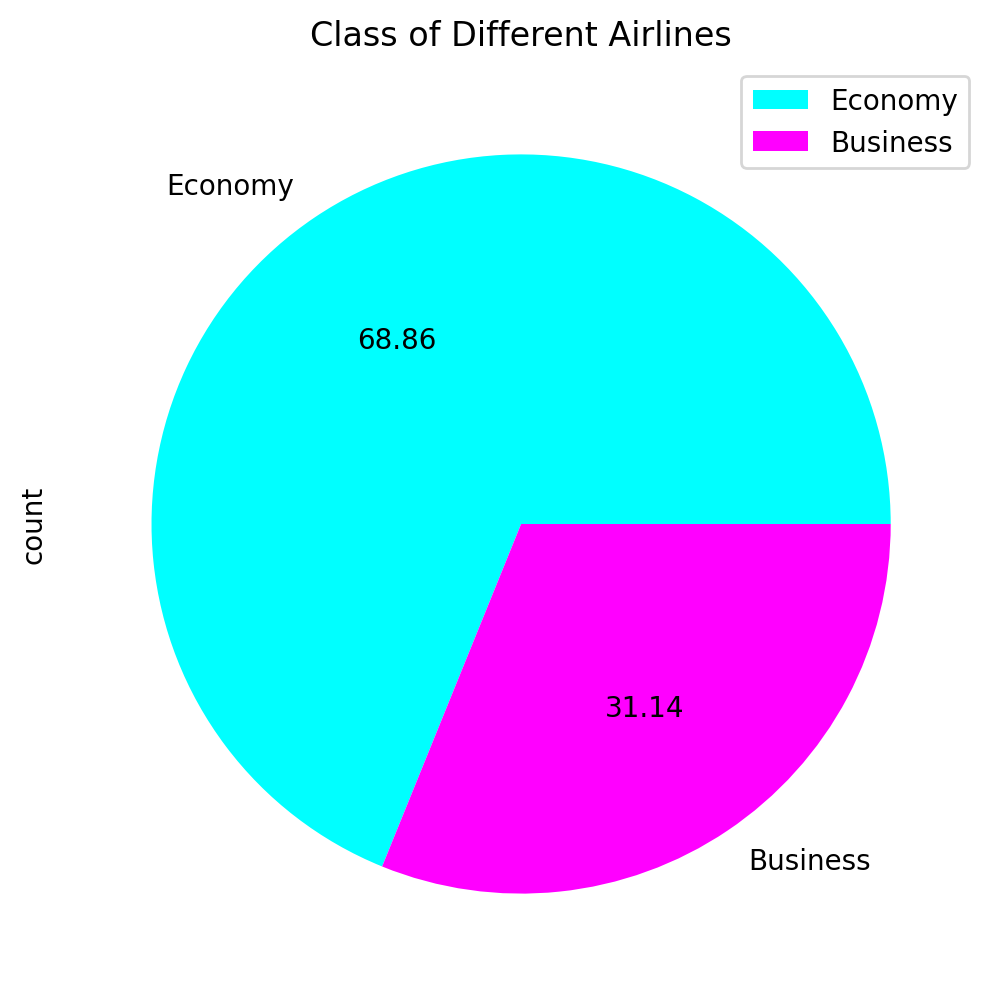

In [ ]:
plt.figure(figsize =(8,6))
df["class"].value_counts().plot(kind ='pie', textprops ={'color':'black'}, cmap='cool', autopct ='%.2f')
plt.legend(['Economy','Business'])
plt.title("Class of Different Airlines")
plt.show()

After that, we created a grouped bar chart to provide insights into the distribution of classes across different airlines through cross-tabulation. We can see that some of the airlines like AirIndia and Vistara do provide Business and Economy services while the rest are focusing on Economy service only. 'Economy' service is generally more preferred compared to Business.

class      Business  Economy
airline                     
Air India     32898    47994
AirAsia           0    16098
GO FIRST          0    23177
Indigo            0    43120
SpiceJet          0     9011
StarAir           0       61
Trujet            0       41
Vistara       60589    67270


<Axes: xlabel='airline'>

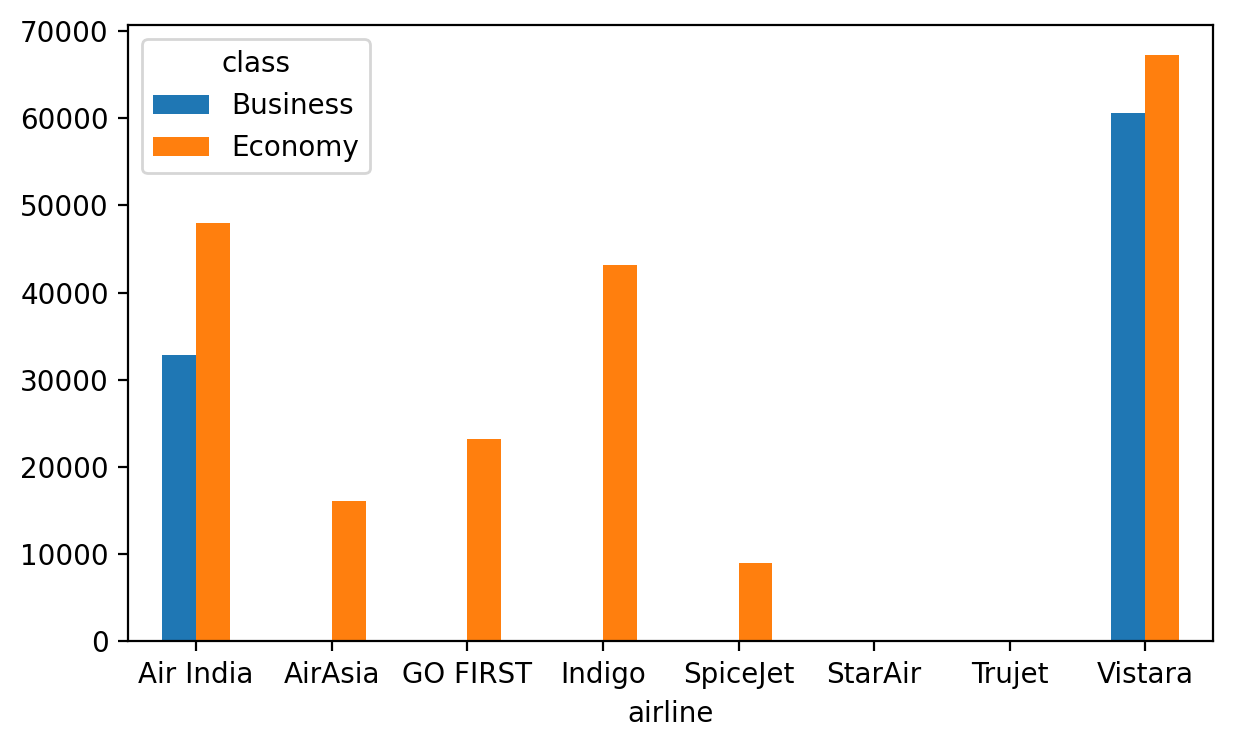

In [ ]:
# Cross tabulation between airline and class
CrosstabResult=pd.crosstab(index=df['airline'],columns=df['class'])
print(CrosstabResult)

# Grouped bar chart between airline and class
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

We also did some visualization of the pricing data in boxplot to see the price distribution by each airline. We can see that most of the airlines here are selling at cheap rates while AirIndia and Vistara's price are generally on the higher end compared to the rest of the airlines.

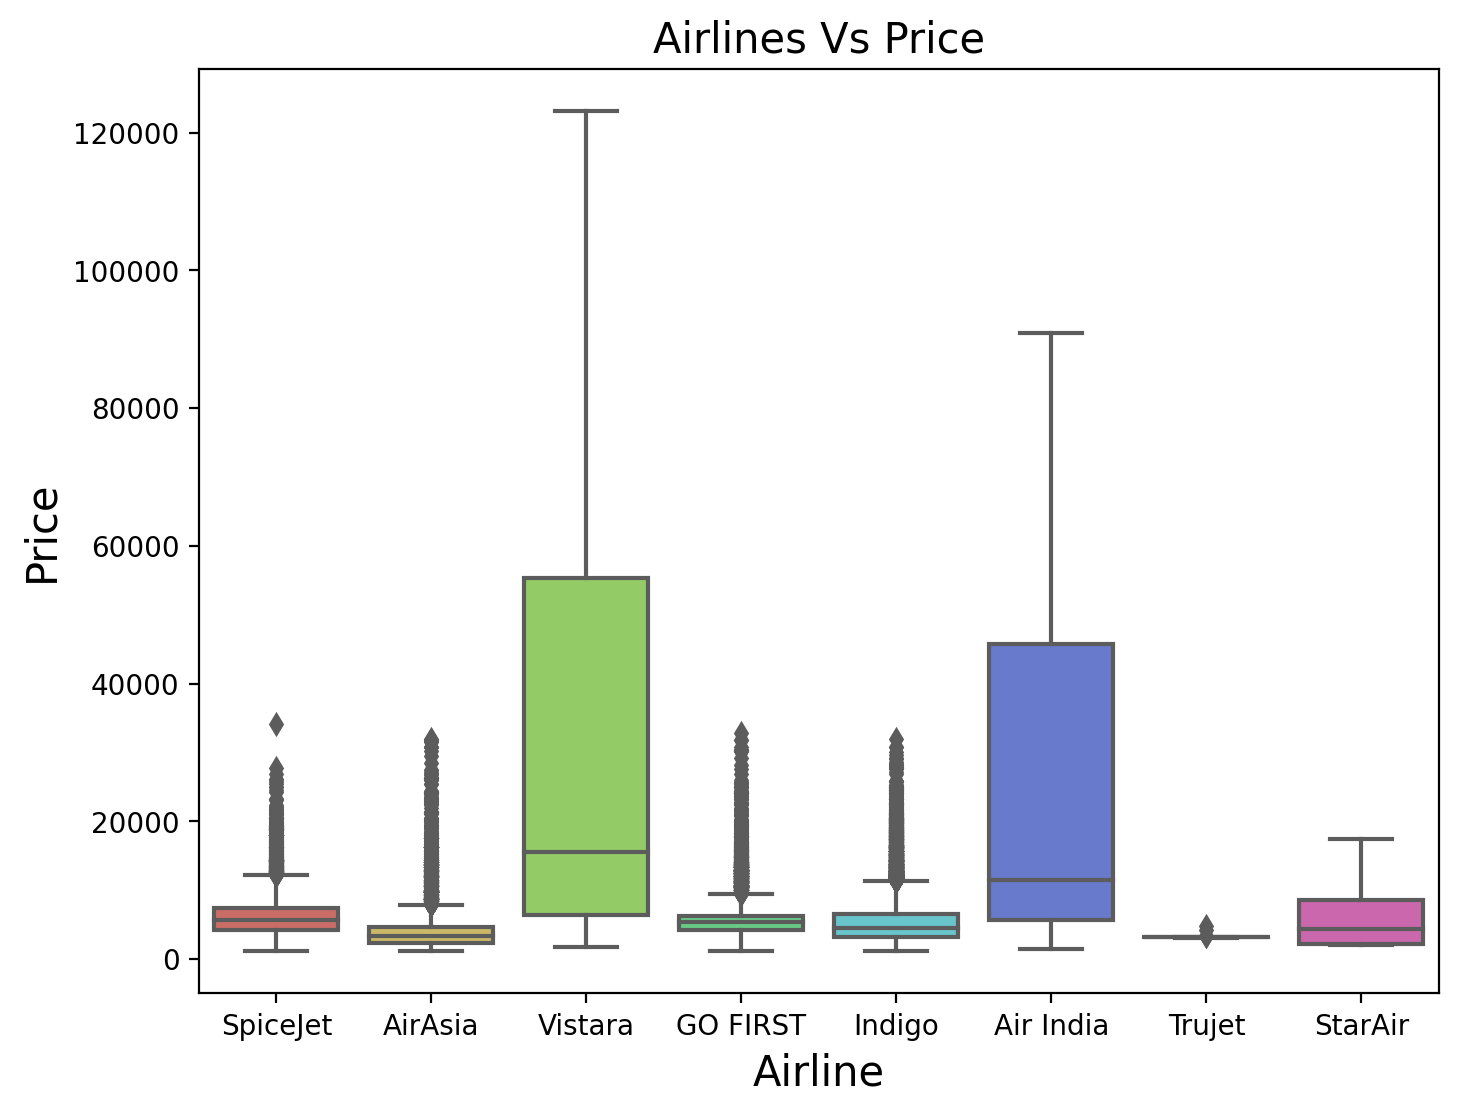

In [ ]:
plt.figure(figsize =(8,6))
sns.boxplot(x=df['airline'], y= df['price'],palette='hls')
plt.title("Airlines Vs Price", fontsize=15)
plt.xlabel("Airline", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.show()

We also visualized the cross-tabulation between two variables, "class" and "destination_city" in a grouped bar chart to see the distribution. We can see that consumers generally prefer to fly in Economy class.

destination_city  Bangalore  Chennai  Delhi  Hyderabad  Kolkata  Mumbai
class                                                                  
Business              16198    13158  16707      13675    14758   18991
Economy               34914    27210  40654      29101    34777   40116


<Axes: xlabel='class'>

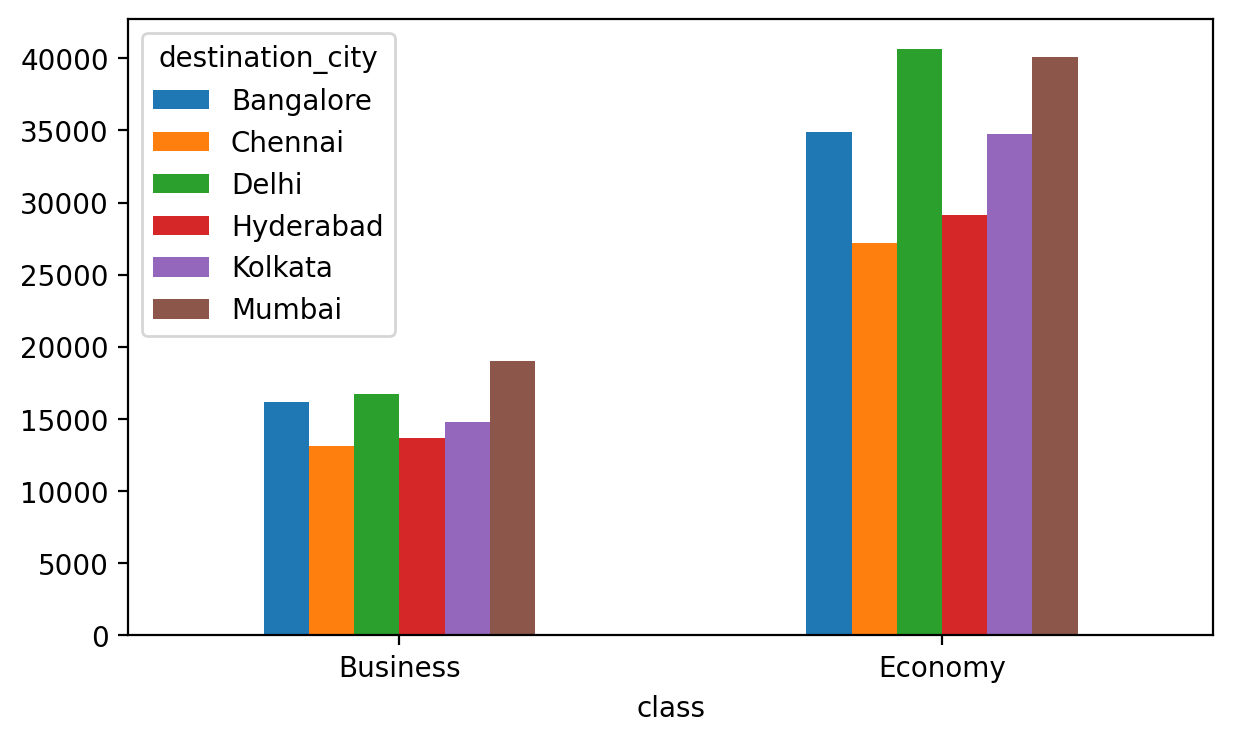

In [ ]:
# Cross tabulation between class and destination
CrosstabResult=pd.crosstab(index=df['class'],columns=df['destination_city'])
print(CrosstabResult)

# Grouped bar chart between class and destination
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

Following that, we created a DataFrame called 'destination' to see frequency of each destination city in the "destination_city" column. We plotted a bar chart and can see the top 3 destinations are Mumbai, Delhi and Bangalore.

In [ ]:
destination= pd.DataFrame({'destination_city':df.destination_city.value_counts().index,'Counts':df.destination_city.value_counts()})
destination

,destination_city,Counts
destination_city,,
Mumbai,Mumbai,59107
Delhi,Delhi,57361
Bangalore,Bangalore,51112
Kolkata,Kolkata,49535
Hyderabad,Hyderabad,42776
Chennai,Chennai,40368


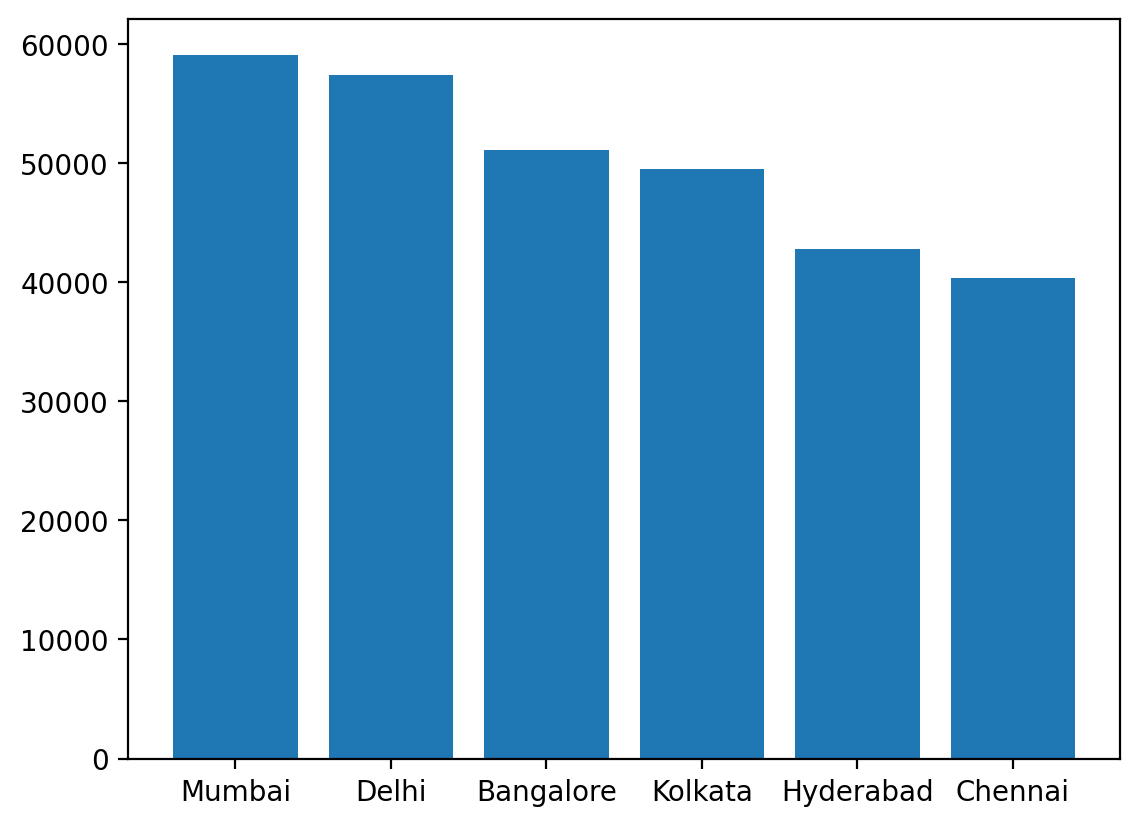

In [ ]:
plt.bar(destination['destination_city'],destination['Counts'])
plt.show()

Then, we visualized the pricing data in boxplot to see the price distribution for each source city and destination city. We can see that Kolkata is the most expensive source and destination city while Delhi is the cheapest source and destination city.

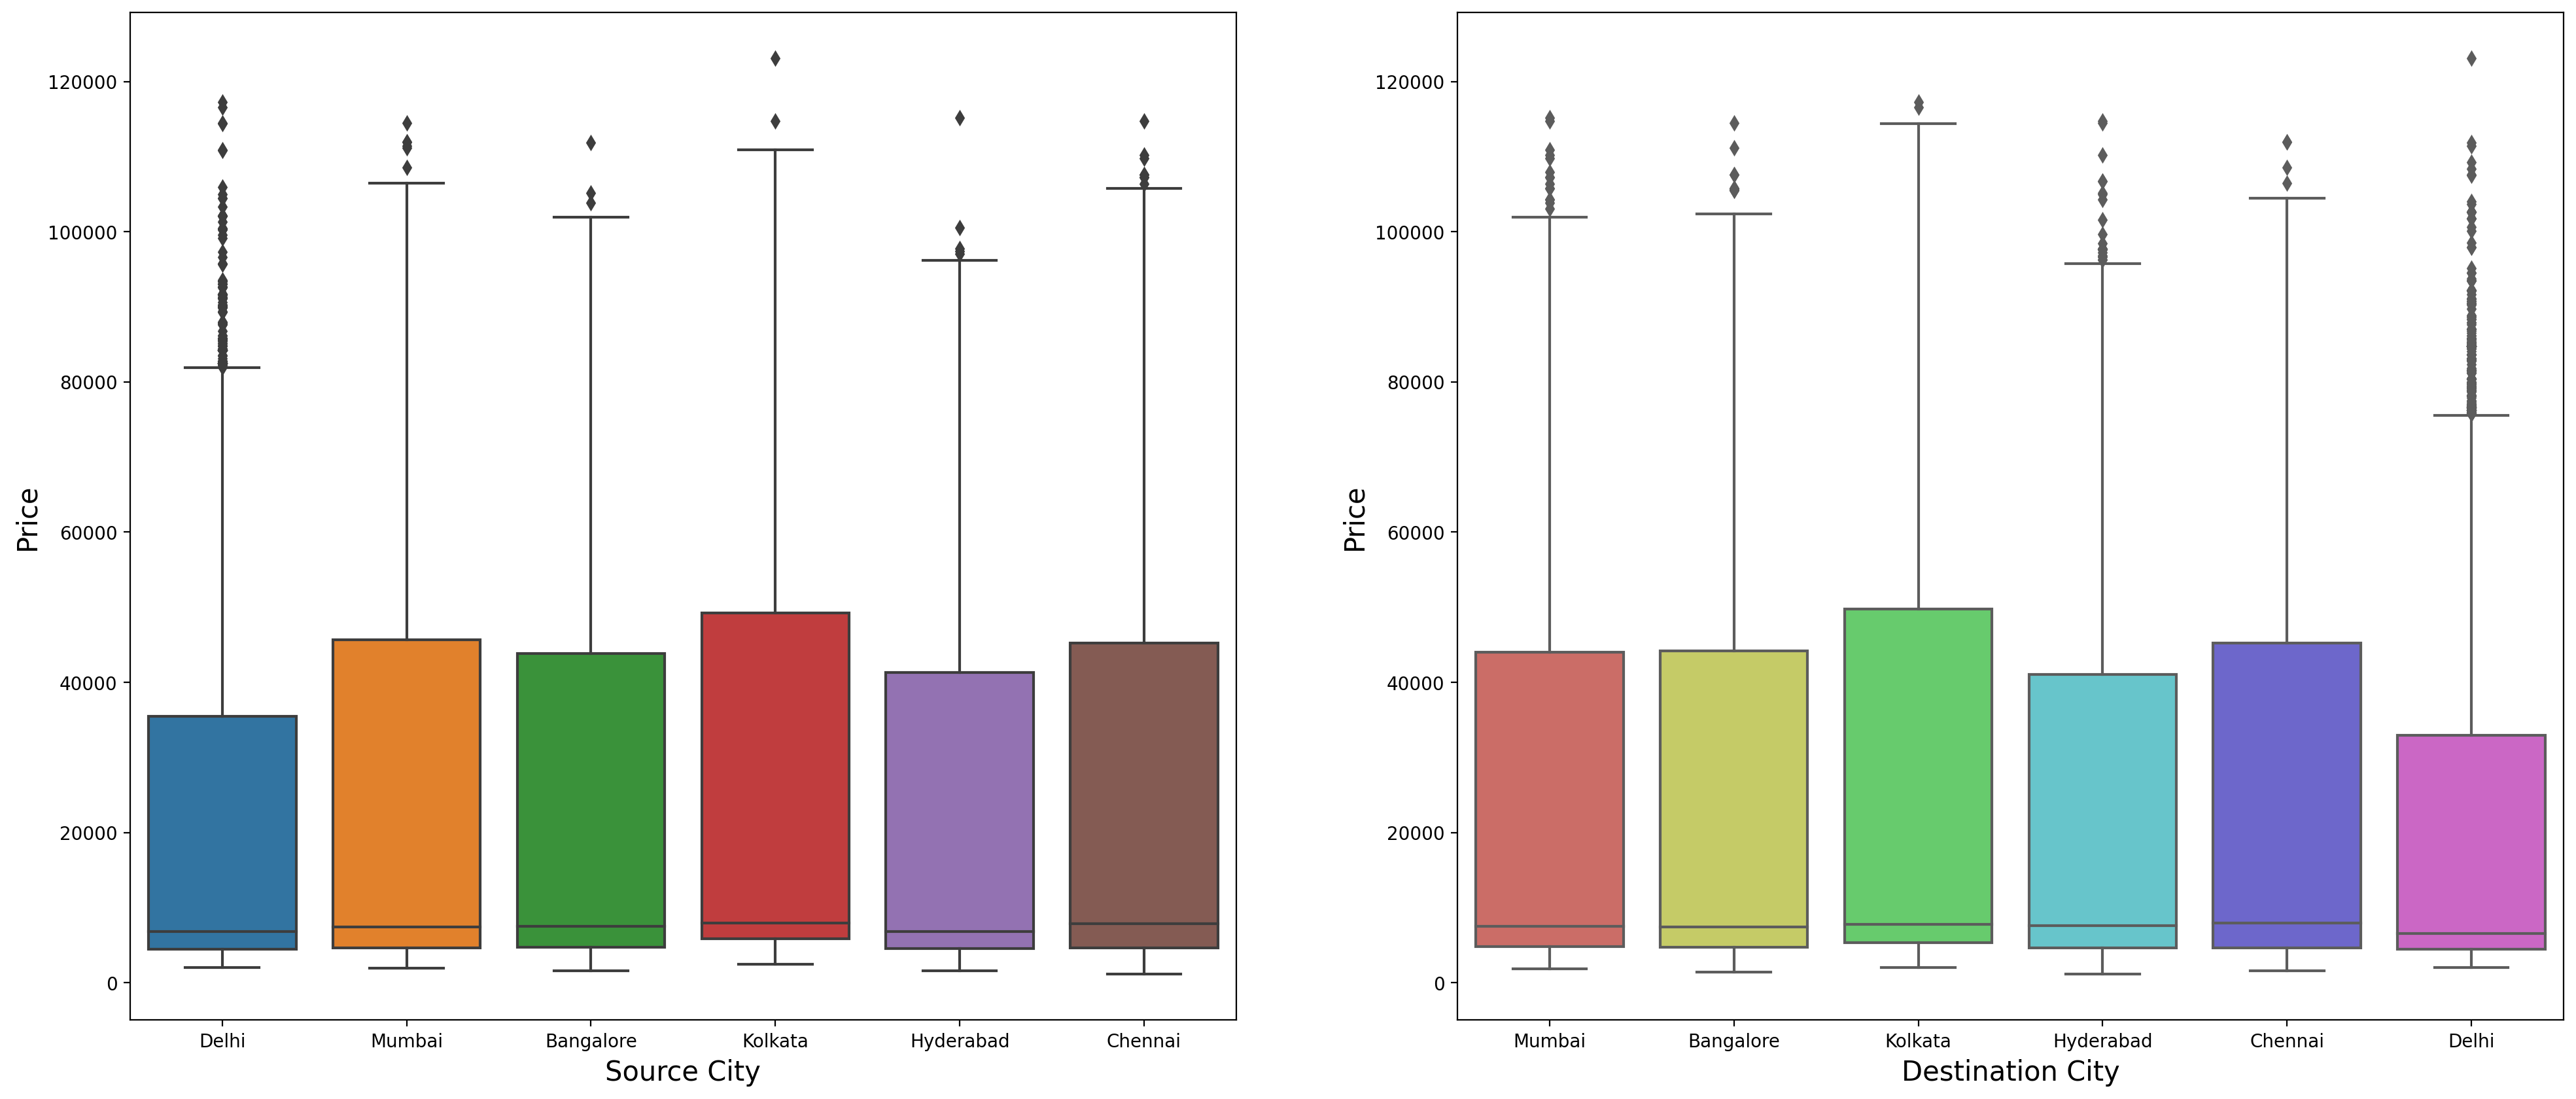

In [ ]:
#To check price distribution based on source and destination city
plt.figure(figsize =(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city', y='price', data = df)
plt.xlabel("Source City", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city', y='price', data=df, palette='hls')
plt.ylabel("Price", fontsize=15)
plt.xlabel("Destination City", fontsize =15)
plt.show()

We also generated a line plot to illustrate the relationship between the number of days left before departure and the price of flight ticket. We can see that price is cheaper when there are huge gap of days between departure date and booking date. For expensive airline like AirIndia and Vistara, we can see there's huge increase closer to the date but the rate significanty dropped when it's closest to the date though it's not as cheap if you buy the ticket earlier. For the rest of the airlines, the prices are generally very expensive when it's super close to the depature date.

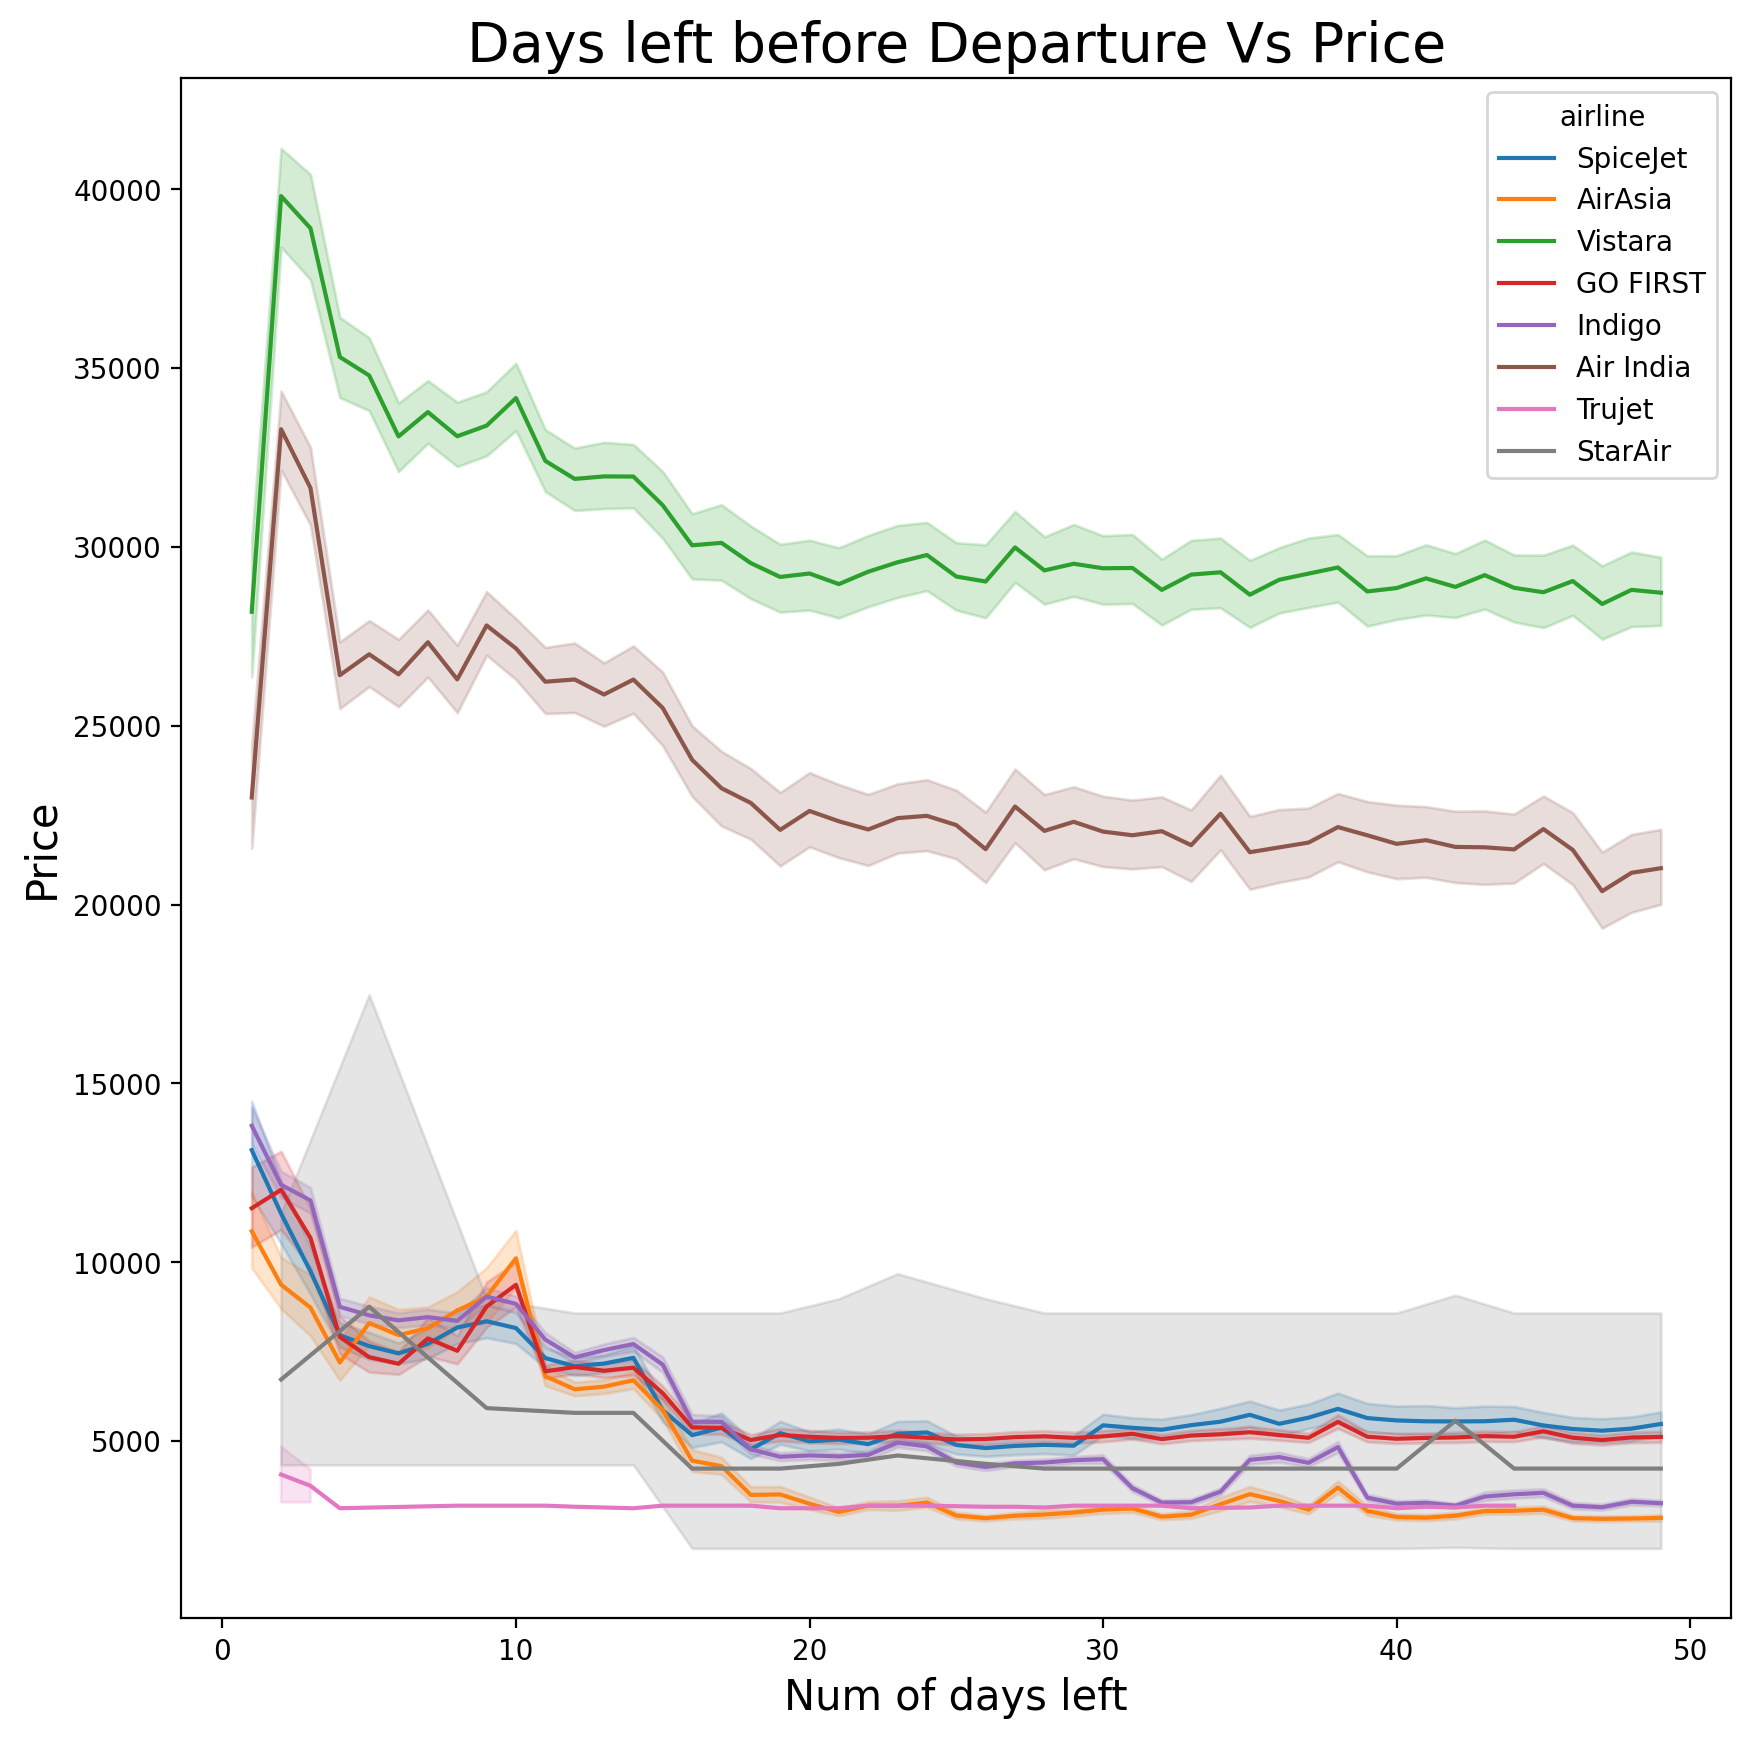

In [ ]:
plt.figure(figsize=(10,10))
plt.xlabel("Num of days left", fontsize=15)
plt.ylabel("Price", fontsize=15)
sns.lineplot(data=df, x='days_left', y='price', hue='airline',color='blue')
plt.title("Days left before Departure Vs Price", fontsize=20)
plt.show()

We generated a heatmap to visualize the correlation between the numerical features and the target variable, "price". The heatmap provides a visual representation of the strength and direction of the linear relationship between these variables.

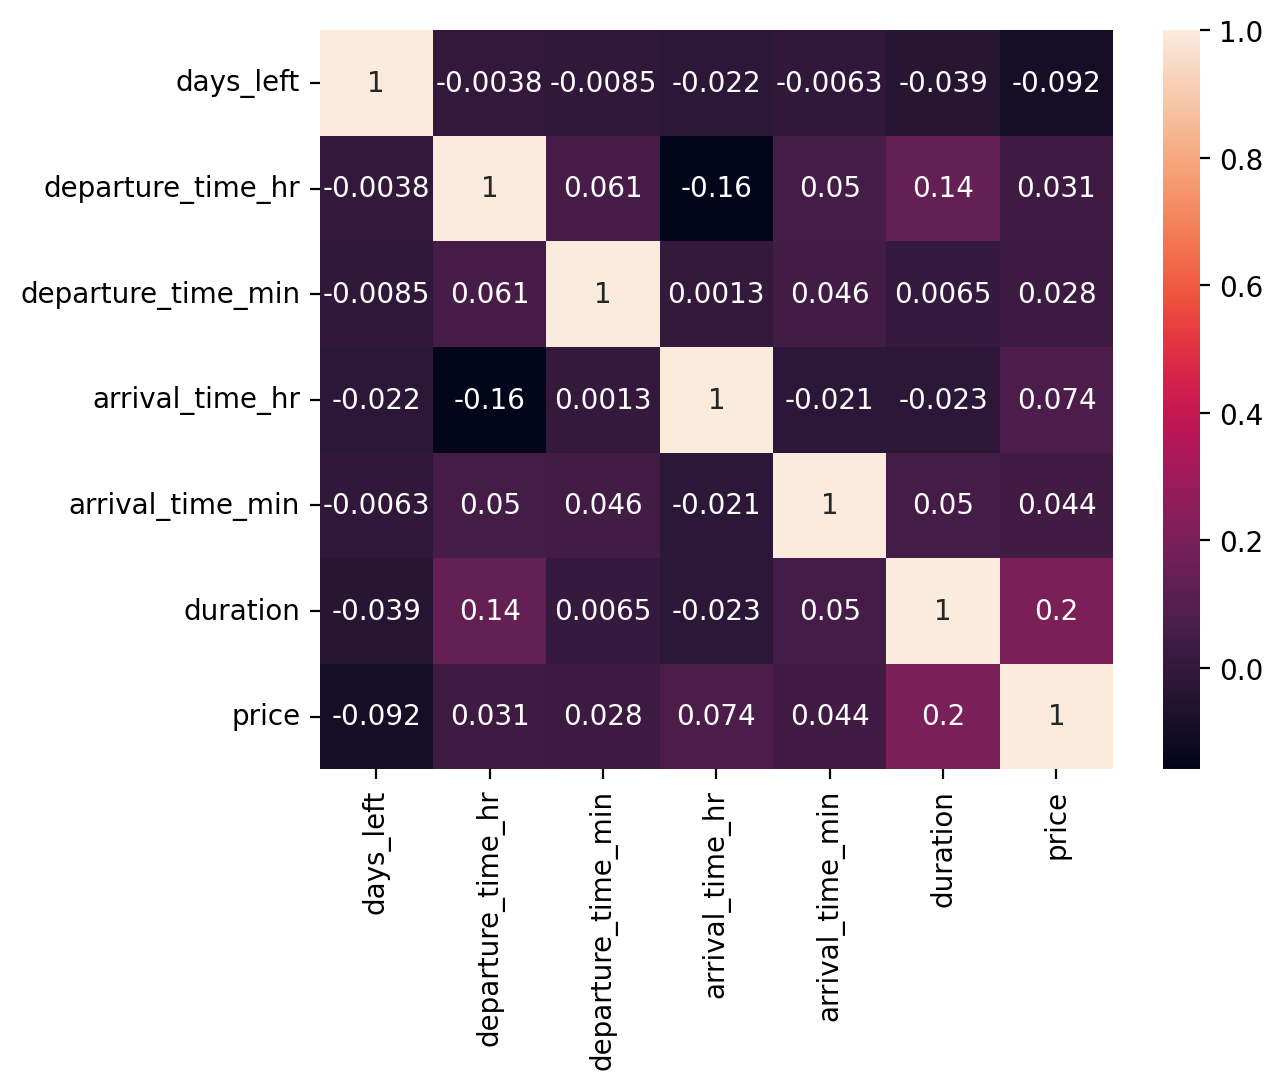

In [ ]:
sns.heatmap(df[numerical_features + [target]].corr(), annot=True)
plt.show()

# 5. Modelling

We decided to go with 3 modelling techniques which are Baselines, Ensemble Learning and Neural Networks to predict flight ticket price. We then calculated various regression evaluation metrics based on the predicted and true target values (y_pred and y_test):

In [ ]:
def reg_scores(y_test, y_pred):
    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

def evaluate(model):
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test = model.predict(X_test_scaled)

    val_mse = mean_squared_error(y_val_scaled, y_pred_val)
    test_mse = mean_squared_error(y_test_scaled, y_pred_test)

    y_pred_test_actual = np.expm1(model.predict(X_test_scaled))
    actual_scores = reg_scores(y_test, y_pred_test_actual)

    return val_mse, test_mse, actual_scores

## 5.1 Baselines

Below codes define a dictionary named 'models' that maps different regression model names to corresponding instances of those models. We also created three empty dictionaries named 'baseline_val_scores', 'baseline_test_scores', and 'baseline_test_scores_actual' to store the evaluation scores for the baseline models.

In [ ]:
models = {
  "Linear Regression": LinearRegression(),
  "Lasso": Lasso(),
  "Ridge": Ridge(),
  "ElasticNet": ElasticNet(),
  "KNN": KNeighborsRegressor(),
  "SVR": LinearSVR(max_iter=2500, random_state=12345),
  "Decision Tree": DecisionTreeRegressor(random_state=12345)
}

baseline_val_scores = dict()
baseline_test_scores = dict()
baseline_test_scores_actual = dict()

This is where we set up a loop that iterates over each key-value pair in the 'models' dictionary. In each iteration, the variable 'name' will hold the key (model name), and the variable 'model' will hold the corresponding value (the regression model object). The fit( ) method functions to train the model on the given input features ('X_train_scaled') and target variable ('y_train_scaled'). After this loop, the models will be trained and ready to make predictions on new data.

In [ ]:
for name, model in models.items():
  model.fit(X_train_scaled, y_train_scaled)

In [ ]:
for name, model in models.items():
  val_mse, test_mse, actual_scores = evaluate(model)

  baseline_val_scores[name] = val_mse
  baseline_test_scores[name] = test_mse
  baseline_test_scores_actual[name] = actual_scores

By iterating over the models dictionary and evaluating each model using the evaluate() function, this loop collects and stores the evaluation scores for each model on the validation and test sets in the respective dictionaries (baseline_val_scores, baseline_test_scores, and baseline_test_scores_actual). These dictionaries can later be used to compare and analyze the performance of different models.

### 5.1.1 Summary

We created a DataFrame named `baseline_val_scores_df` that is constructed from two dictionaries: `baseline_val_scores` and `baseline_test_scores`containing the validation mean squared error (MSE) scores and test MSE scores, respectively.

The `index` parameter is set to `baseline_val_scores.keys()`, which assigns the keys from the `baseline_val_scores` dictionary as the index for the DataFrame. This ensures that each MSE score is associated with its respective key.

Next, `baseline_val_scores_df.plot.bar()` function is used to generate a bar plot from the variable `ax`.
We iterated over each bar patch (`p`) using a `for` loop. The x-coordinate of the patch is retrieved using `p.get_x()`, and the height of the bar is obtained with `p.get_height()`. The height is incremented by 0.01 to position the annotation slightly above the bar.

The `label` variable is formatted using f-strings to round the height value to four decimal places (`np.round(p.get_height(), 4):.4f`). The `ax.annotate()` function is used to annotate the bar. It takes the label, coordinates `(x, y)`, horizontal alignment (`ha`), and rotation angle as arguments.

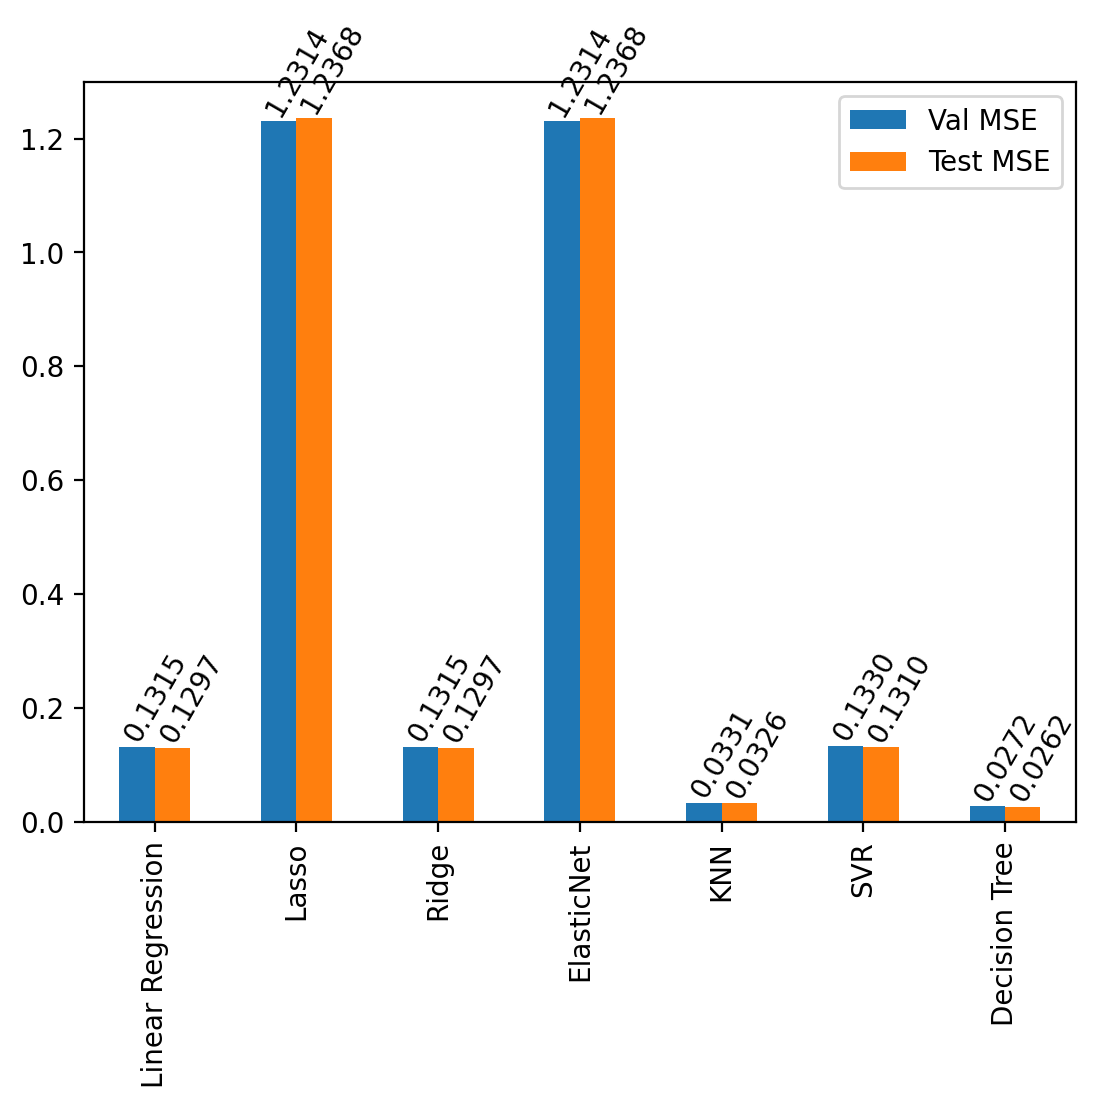

In [ ]:
baseline_val_scores_df = pd.DataFrame(
  {
    "Val MSE": baseline_val_scores.values(),
    "Test MSE": baseline_test_scores.values()
  },
  index=baseline_val_scores.keys()
)

ax = baseline_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x()
    y = p.get_height() + 0.01
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

We then took a dictionary of actual test scores, converted it into a DataFrame, transposed it, and then sorted the DataFrame based on the "R2" column in descending order:

In [ ]:
pd.DataFrame(baseline_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
Decision Tree,1021.222264,0.065686,1.019455e+07,3192.890574,0.980236
KNN,1693.975492,0.101413,1.284254e+07,3583.648746,0.975103
SVR,4653.007943,0.293158,6.035407e+07,7768.788220,0.882995
Linear Regression,4974.824656,0.296780,7.203187e+07,8487.158999,0.860356
Ridge,4975.055073,0.296785,7.203928e+07,8487.595455,0.860342
Lasso,16620.790755,1.143725,6.073659e+08,24644.795409,-0.177464
ElasticNet,16620.790755,1.143725,6.073659e+08,24644.795409,-0.177464


## 5.2 Ensemble Learning

We created three empty dictionaries: `ensemble_val_scores`, `ensemble_test_scores`, and `ensemble_test_scores_actual`for storing and organizing the evaluation scores for different ensemble models:

In [ ]:
ensemble_val_scores = dict()
ensemble_test_scores = dict()
ensemble_test_scores_actual = dict()

### 5.2.1 Random Forest

The first line below indicates the training process of a Random Forest model. It initializes a Random Forest regressor with 50 estimators and `-1` for `n_jobs` to utilize all available processors. Then, it fits the model using the scaled training data (`X_train_scaled` and `y_train_scaled`).

After training, the model is saved using the `dump()` as a joblib file (`random_forest.joblib`) with compression level 3.

In the next line, the model is loaded using the `load()` function from the `joblib` library.The `evaluate()` function took the `random_forest` model and performs evaluation. It returns the validation mean squared error (`val_mse`), test mean squared error (`test_mse`), and actual scores (`actual_scores`).

The results from the evaluation are stored in the `ensemble_val_scores`, `ensemble_test_scores`, and `ensemble_test_scores_actual` dictionaries:

In [ ]:
# random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1)
# random_forest.fit(X_train_scaled, y_train_scaled)

# dump(random_forest, "artifacts/random_forest.joblib", compress=3)
random_forest = load("artifacts/random_forest.joblib")

val_mse, test_mse, actual_scores = evaluate(random_forest)

ensemble_val_scores["Random Forest"] = val_mse
ensemble_test_scores["Random Forest"] = test_mse
ensemble_test_scores_actual["Random Forest"] = actual_scores

### 5.2.2 XGBoost

We moved on to the next part which is the XGBoost technique.
The hyperparameters defined in the `space` dictionary include:
   - `max_depth`: Integer values between 3 and 18 (inclusive).
   - `gamma`: Continuous values between 1 and 9.
   - `reg_alpha`: Integer values between 40 and 180 (inclusive).
   - `reg_lambda`: Continuous values between 0 and 1.
   - `colsample_bytree`: Continuous values between 0.5 and 1.
   - `min_child_weight`: Integer values between 0 and 10 (inclusive).
   - `n_estimators`: Integer values between 100 and 100,000 (inclusive).
   - `seed`: A fixed value of 0.

The `objective()` function with an `XGBRegressor` model is created with the hyperparameters specified by `space`. The hyperparameters are accessed from the `space` dictionary and cast to the appropriate types (integers or floats) where necessary.

The `XGBRegressor` model is then trained using the `fit()` method, with the scaled training data (`X_train_scaled` and `y_train_scaled`). The `eval_set` parameter specifies the validation set data `(X_val_scaled, y_val_scaled)` for early stopping during training. The `verbose` parameter is set to `False` to suppress output during training.

After training, the model makes predictions (`y_pred`) on the validation data (`X_val_scaled`), and the mean squared error (`score`) is calculated using the `mean_squared_error()` function.

Finally, the `objective()` function returns a dictionary with two keys:
- `'loss'`: The value of the mean squared error (`score`).
- `'status'`: A status indicator (`STATUS_OK`) to show the completion of the evaluation for the given hyperparameters.

In [ ]:
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform ("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree" : hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight" : hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": hp.quniform("n_estimators", 100, 100000, 1),
    "seed": 0
}

def objective(space):
    model = XGBRegressor(
        early_stopping_rounds=10,
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space["reg_alpha"]),
        reg_lambda=space["reg_lambda"],
        colsample_bytree=space["colsample_bytree"],
        min_child_weight=int(space["min_child_weight"]),
        n_estimators=int(space["n_estimators"])
    )

    model.fit(
        X_train_scaled,
        y_train_scaled,
        eval_set=[(X_val_scaled, y_val_scaled)],
        verbose=False
    )

    y_pred = model.predict(X_val_scaled)
    score = mean_squared_error(y_pred, y_val_scaled)

    return {'loss': score, 'status': STATUS_OK }

We created `Trials()` object, and it serves as a container to store the results and information about the optimization process.

`fmin()` function is used to execute the optimization process by iteratively sampling sets of hyperparameters from the search space, evaluating them using the objective function, and updating the `Trials()` object with the results. The function takes several arguments:
   - `fn`: The objective function to optimize. In this case, it is the `objective()` function defined earlier.
   - `space`: The search space dictionary that defines the range or distribution of the hyperparameters.
   - `algo`: The algorithm to use for the optimization process. `tpe.suggest` represents the Tree Parzen Estimator algorithm, a popular choice for Bayesian optimization.
   - `max_evals`: The maximum number of evaluations or iterations to perform during the optimization process.
   - `trials`: The `Trials()` object that will store the information and results of each evaluation.

The return value of `fmin()` is typically stored in a variable like `best_hyperparams`. It represents the best set of hyperparameters found during the optimization process, which minimizes the loss function (mean squared error in this case)

In [ ]:
trials = Trials()

# best_hyperparams = fmin(
#     fn=objective,
#     space=space,
#     algo=tpe.suggest,
#     max_evals=100,
#     trials=trials
# )

We created `xgb_params` dictionary that contains a set of hyperparameters for the XGBoost regressor.

The commented lines show the initialization of an XGBoost regressor (`xgb`) with the hyperparameters provided in `xgb_params`. However, the hyperparameters are commented out, and instead, default values or other specified values are used for some hyperparameters.

The `XGBRegressor` model is trained using the `fit()` method. It is trained on the scaled training data (`X_train_scaled` and `y_train_scaled`). The `eval_set` parameter is used to specify the validation set data (`X_val_scaled` and `y_val_scaled`).

The trained model is then saved using the `dump()` function named "xgboost.joblib" with compression level 3.

Afterward, the model is loaded using the `load()` function from the `joblib` library. The `evaluate()` function took the `xgb` model and performs evaluation. It returns the validation mean squared error (`val_mse`), test mean squared error (`test_mse`), and actual scores (`actual_scores`).

The results from the evaluation are stored in the `ensemble_val_scores`, `ensemble_test_scores`, and `ensemble_test_scores_actual` dictionaries.

In [ ]:
xgb_params = {
    "colsample_bytree": 0.8545834573974018,
    "gamma": 1.0149990564873104,
    "max_depth": 17,
    "min_child_weight": 8.0,
    "n_estimators": 5149,
    "reg_alpha": 40.0,
    "reg_lambda": 0.0008085443779402013
}

# xgb = XGBRegressor(
#     # **xgb_params,
#     n_estimators=10000,
#     early_stopping_rounds=25,
#     n_jobs=-1
# )

# xgb.fit(
#   X_train_scaled,
#   y_train_scaled,
#   eval_set=[(X_val_scaled, y_val_scaled)],
#   verbose=250
# )

# dump(xgb, "artifacts/xgboost.joblib", compress=3)
xgb = load("artifacts/xgboost.joblib")

val_mse, test_mse, actual_scores = evaluate(xgb)

ensemble_val_scores["XGBoost"] = val_mse
ensemble_test_scores["XGBoost"] = test_mse
ensemble_test_scores_actual["XGBoost"] = actual_scores

Then, we did the calculation and visualization of feature importance for an XGBoost model.

`xgb_importance` is a dictionary that represents the feature importance of the XGBoost model. The `get_booster()` method is used to obtain the underlying booster model, and the `get_score()` method is called with `importance_type='weight'` to retrieve the feature importance based on the number of times each feature is used in the tree ensemble.

`xgb_importance_named` is an empty dictionary that will store the feature importance values with feature names instead of indices.

The code then iterates over the items in `xgb_importance`. Each item represents a feature index (`i`) and its corresponding importance weight (`weight`).

Inside the loop, the feature name is obtained by slicing the feature index and mapping it to the corresponding feature name from the `features` list (assuming `features` is a list containing the feature names in the same order as used during training).

The feature name and its importance weight are added to the `xgb_importance_named` dictionary.

After the loop, `xgb_importance_named` is sorted by the importance values in ascending order using the `sorted()` function. The `key` parameter is set to `lambda item: item[1]`, which specifies that the sorting should be based on the values of the dictionary items.

The code then plots a horizontal bar chart using `plt.barh()`. The feature names are passed as the list of keys from `xgb_importance_named`, and the importance values are passed as the list of values. This creates a bar chart where each bar represents the importance of a feature.

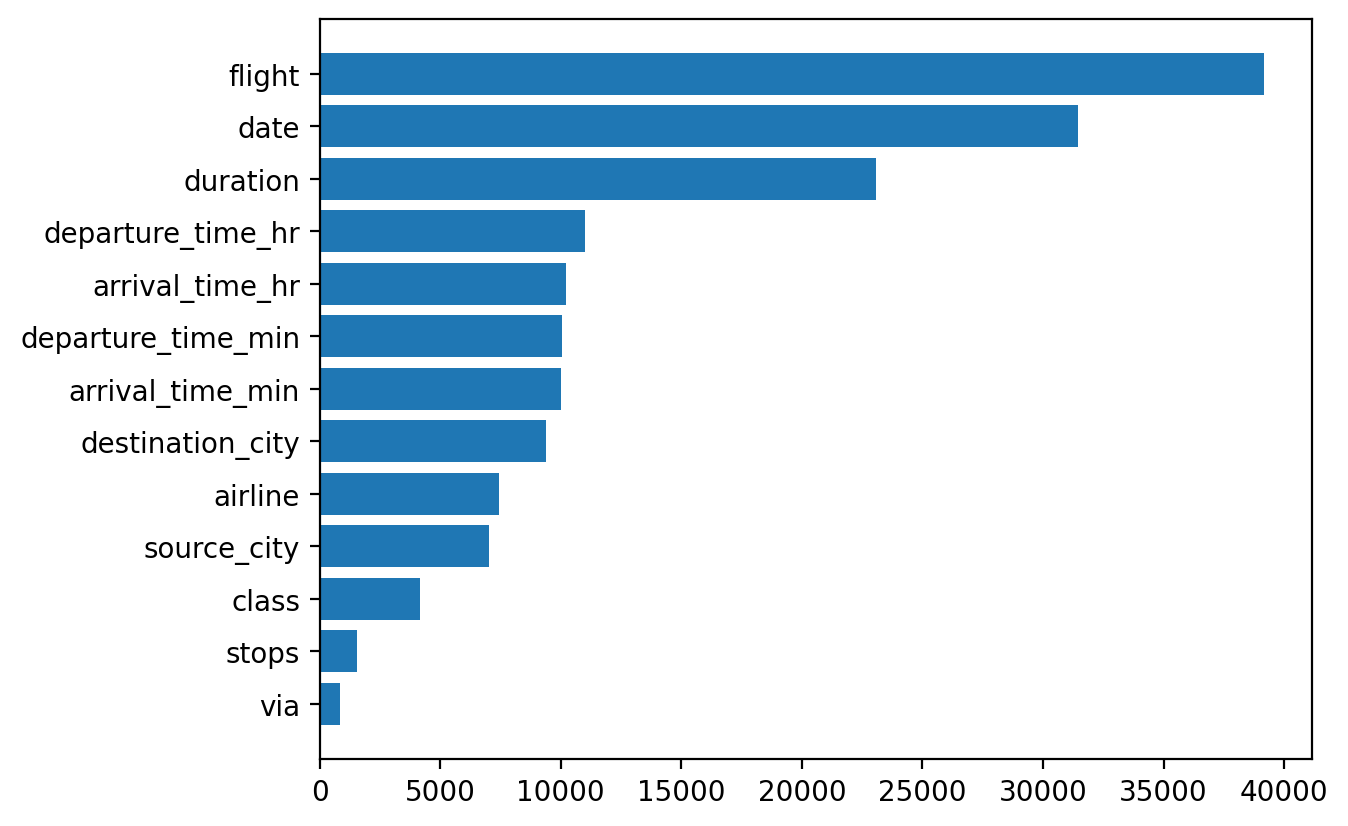

In [ ]:
xgb_importance = xgb.get_booster().get_score(importance_type='weight')
xgb_importance_named = dict()

for i, weight in xgb_importance.items():
  xgb_importance_named[features[int(i[1:])]] = weight

xgb_importance_named = dict(sorted(xgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(xgb_importance_named.keys()), xgb_importance_named.values())
plt.show()

### 5.2.3 LightGBM

The code below is for the usage of a LightGBM regressor model for training, evaluation, and storing the results.

The commented lines show the initialization of a LightGBM regressor (`lgb`) with certain hyperparameters. However, the hyperparameters are commented out, and instead, default values or other specified values are used.

The `LGBMRegressor` model is trained using the `fit()` method. It is trained on the scaled training data (`X_train_scaled` and `y_train_scaled`). The `eval_set` parameter is used to specify the validation set data (`X_val_scaled` and `y_val_scaled`).

During training, the `log_evaluation()` callback is used with a `period` of 500. This means that evaluation results are logged every 500 iterations during the training process.

The trained model is then saved using the `dump()` function named "lightgbm.joblib" with compression level 3.

Afterward, the model is loaded using the `load()` function from the `joblib` library. The `evaluate()` function took the `lgb` model and performs evaluation. It returns the validation mean squared error (`val_mse`), test mean squared error (`test_mse`), and actual scores (`actual_scores`).

The results from the evaluation are stored in the `ensemble_val_scores`, `ensemble_test_scores`, and `ensemble_test_scores_actual` dictionaries.

In [ ]:
# lgb = LGBMRegressor(n_estimators=10000, early_stopping_round=25)

# lgb.fit(
#   X_train_scaled,
#   y_train_scaled,
#   eval_set=(X_val_scaled, y_val_scaled),
#   callbacks=[log_evaluation(period=500)]
# )

# dump(lgb, "artifacts/lightgbm.joblib", compress=3)
lgb = load("artifacts/lightgbm.joblib")

val_mse, test_mse, actual_scores = evaluate(lgb)

ensemble_val_scores["LightGBM"] = val_mse
ensemble_test_scores["LightGBM"] = test_mse
ensemble_test_scores_actual["LightGBM"] = actual_scores

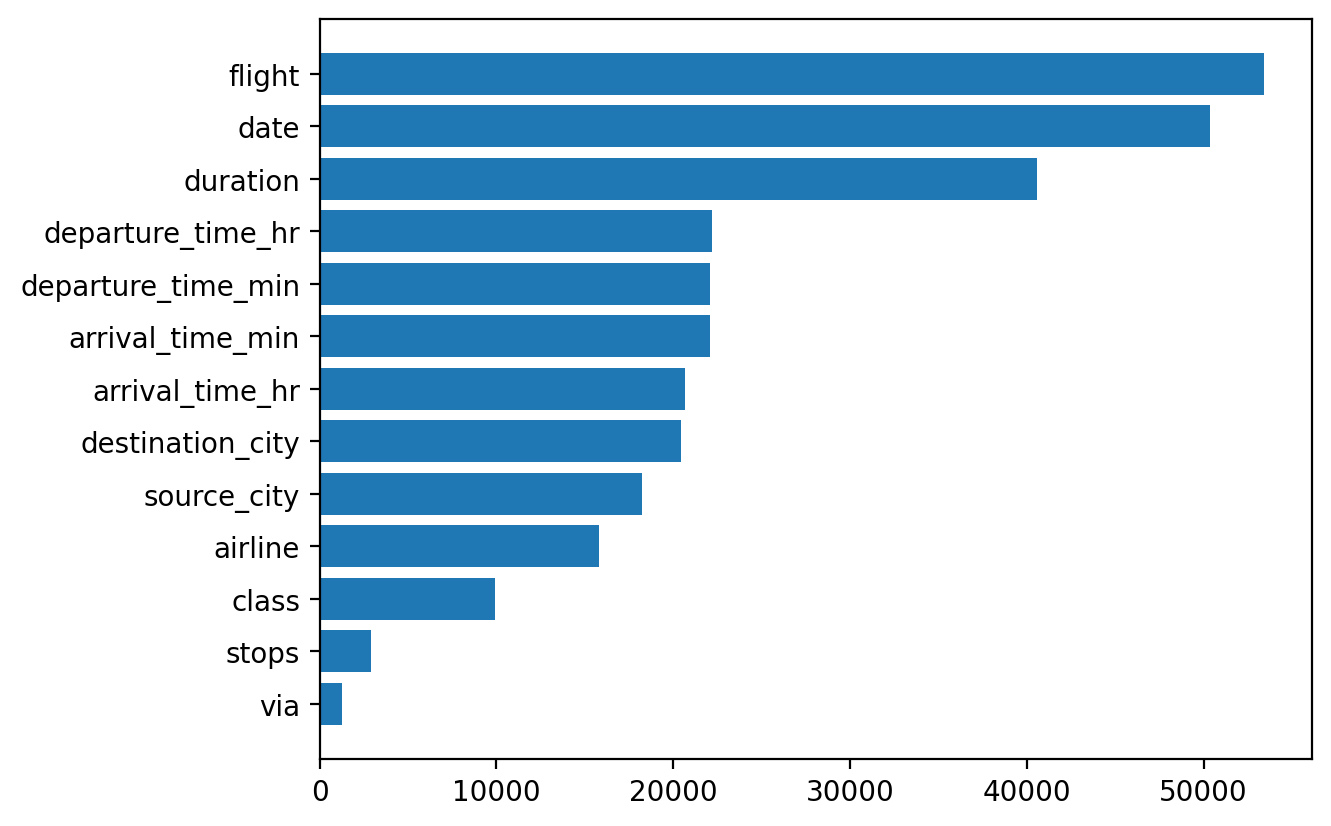

In [ ]:
lgb_importance_named = dict()

for i, weight in enumerate(lgb.feature_importances_):
  if weight == 0:
    continue

  lgb_importance_named[features[i]] = weight

lgb_importance_named = dict(sorted(lgb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(lgb_importance_named.keys()), lgb_importance_named.values())
plt.show()

As you can see above, this is where we do the calculation and visualization of feature importance for a LightGBM model

`lgb_importance_named` is an empty dictionary that will store the feature importance values with feature names.
We then iterated over the `lgb.feature_importances_` attribute, which represents the feature importance values calculated by the LightGBM model. The `enumerate()` function is used to get both the index `i` and the corresponding importance weight `weight`.

Inside the loop, the code checks if the importance weight is zero. If it is zero, the `continue` statement is used to skip the current iteration and move to the next one. If the importance weight is not zero, the feature name corresponding to the index `i` is added to the `lgb_importance_named` dictionary as a key, with the importance weight as the value.

After the loop, `lgb_importance_named` is sorted by the importance values in ascending order using the `sorted()` function. The `key` parameter is set to `lambda item: item[1]`, which specifies that the sorting should be based on the values of the dictionary items.

Then, we plotted a horizontal bar chart using `plt.barh()`. The feature names are passed as the list of keys from `lgb_importance_named`, and the importance values are passed as the list of values. This creates a bar chart where each bar represents the importance of a feature.

### 5.2.4 CatBoost

Following that, we also used CatBoost regressor model.

Here you can see the commented lines show the initialization of a CatBoost regressor (`catb`) with certain hyperparameters. However, the hyperparameters are commented out, and instead, default values or other specified values are used.

The `CatBoostRegressor` model is trained using the `fit()` method. It is trained on the scaled training data (`X_train_scaled` and `y_train_scaled`). The `eval_set` parameter is used to specify the validation set data (`X_val_scaled` and `y_val_scaled`).

During training, the `metric_period` parameter is set to 500. This means that the evaluation metric is calculated and printed every 500 iterations during the training process.

The trained model is then saved using the `dump()` function named "catboost.joblib" with compression level 3.

Afterward, the model is loaded using the `load()` function from the `joblib` library. The `evaluate()` function took the `catb` model and performs evaluation. It returns the validation mean squared error (`val_mse`), test mean squared error (`test_mse`), and actual scores (`actual_scores`).

The results from the evaluation are stored in the `ensemble_val_scores`, `ensemble_test_scores`, and `ensemble_test_scores_actual` dictionaries.

In [ ]:
# catb = CatBoostRegressor(n_estimators=10000, early_stopping_rounds=25)

# catb.fit(
#   X_train_scaled,
#   y_train_scaled,
#   eval_set=(X_val_scaled, y_val_scaled),
#   metric_period=500
# )

# dump(catb, "artifacts/catboost.joblib", compress=3)
catb = load("artifacts/catboost.joblib")

val_mse, test_mse, actual_scores = evaluate(catb)

ensemble_val_scores["CatBoost"] = val_mse
ensemble_test_scores["CatBoost"] = test_mse
ensemble_test_scores_actual["CatBoost"] = actual_scores

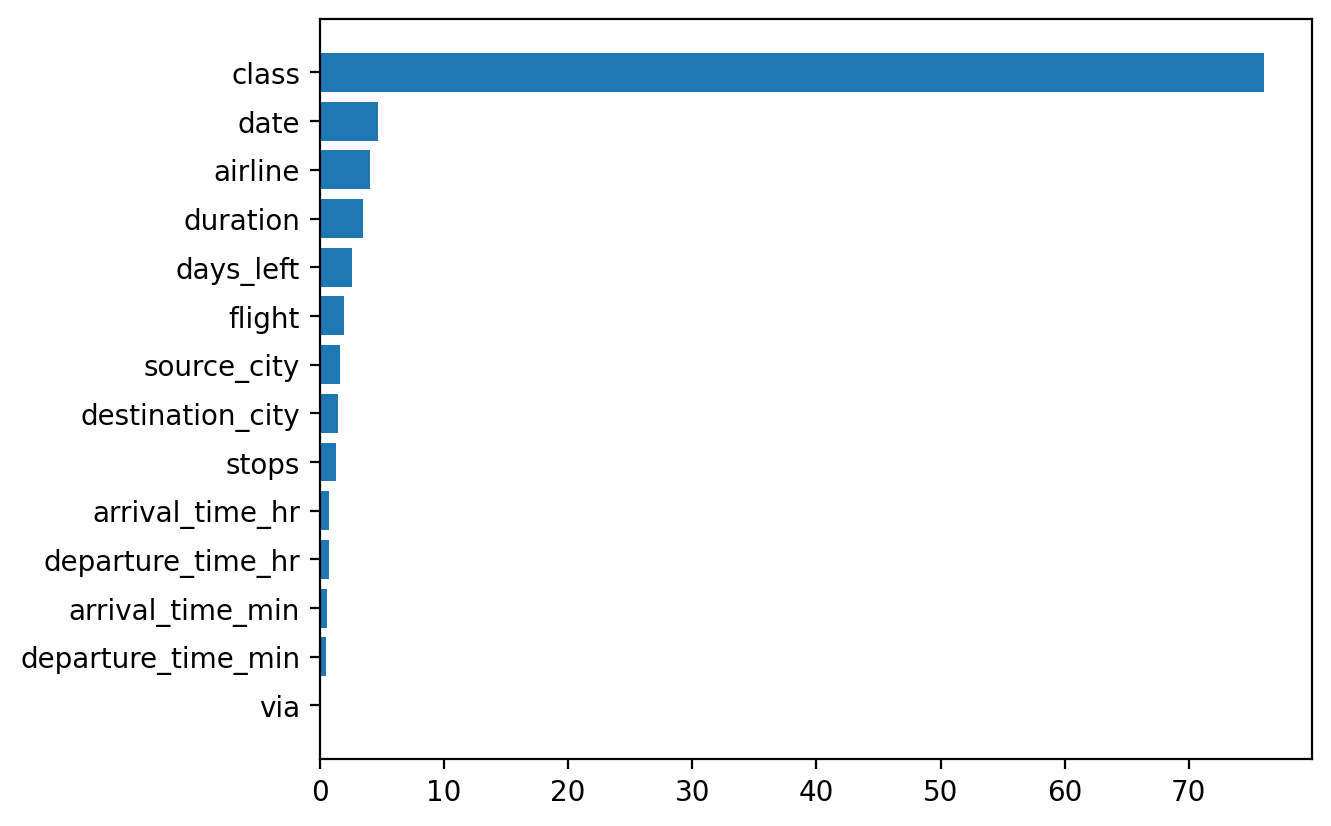

In [ ]:
catb_importance_named = dict()

for i, weight in enumerate(catb.feature_importances_):
  catb_importance_named[features[i]] = weight

catb_importance_named = dict(sorted(catb_importance_named.items(), key=lambda item: item[1]))

plt.barh(list(catb_importance_named.keys()), catb_importance_named.values())
plt.show()

For the visualization of this CatBoost, below are what we did:

`catb_importance_named` is an empty dictionary that will store the feature importance values with feature names.

The code uses the `enumerate()` function to iterate over the feature importances of the CatBoost model. The `enumerate()` function provides both the index `i` and the corresponding importance weight `weight` for each feature.

Inside the loop, the code assigns the feature name corresponding to the index `i` as a key in the `catb_importance_named` dictionary, with the importance weight as the value.

After the loop, the `catb_importance_named` dictionary is sorted based on the importance values in ascending order. This is done using the `sorted()` function with the `key` parameter set to `lambda item: item[1]`. It specifies that the sorting should be based on the values of the dictionary items.

The code then plots a horizontal bar chart using `plt.barh()`. The feature names are passed as the list of keys from `catb_importance_named`, and the importance values are passed as the list of values. This creates a bar chart where each bar represents the importance of a feature.

### 5.2.5 Summary

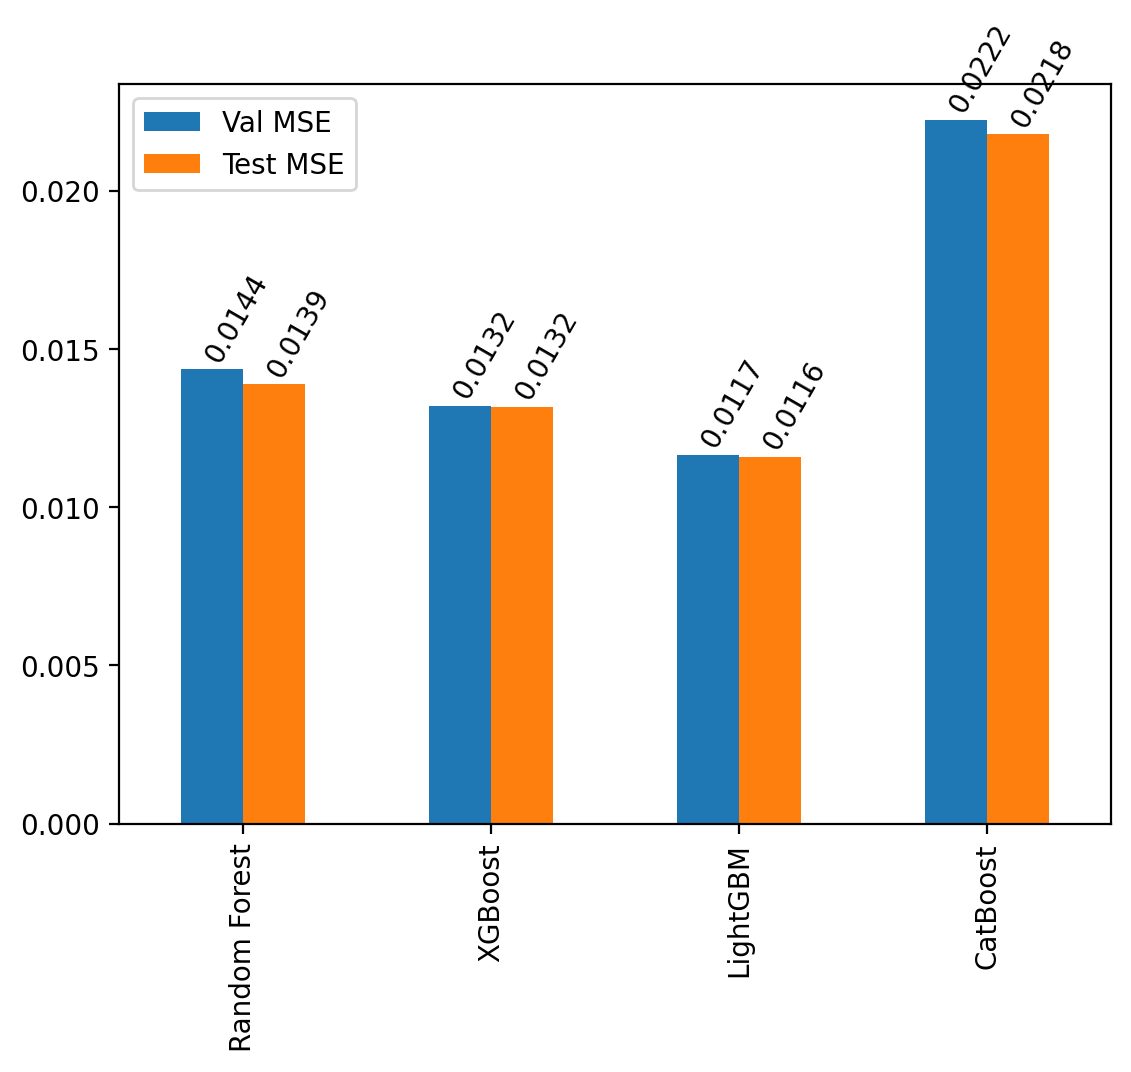

In [ ]:
ensemble_val_scores_df = pd.DataFrame(
  {
    "Val MSE": ensemble_val_scores.values(),
    "Test MSE": ensemble_test_scores.values()
  },
  index=ensemble_val_scores.keys()
)

ax = ensemble_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.075
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

We then created a bar plot to visualize the validation and test mean squared error (MSE) scores for the ensemble models.

The `ensemble_val_scores` and `ensemble_test_scores` dictionaries are assumed to contain the validation MSE scores and test MSE scores for the ensemble models, respectively.

The `pd.DataFrame()` function is called to create a new DataFrame object named `ensemble_val_scores_df`. Inside the function, a dictionary is constructed with two key-value pairs and the corresponding values will be the MSE scores.

The `index` parameter is set to `ensemble_val_scores.keys()`, which assigns the keys from the `ensemble_val_scores` dictionary as the index for the DataFrame.


Next, the bar plot is created and assigned to the variable `ax`.

The following section of the code sets up annotations for each bar in the plot. It iterates over each bar patch (`p`) using a `for` loop. The x-coordinate of the patch is retrieved using `p.get_x()` and incremented by 0.075 to adjust the annotation's position. The height of the bar is obtained with `p.get_height()` and incremented by 0.00025 to position the annotation slightly above the bar.

The `label` variable is formatted using f-strings to round the height value to four decimal places (`np.round(p.get_height(), 4):.4f`).

The `ax.annotate()` function is used to annotate the bar. It takes the label, coordinates `(x, y)`, horizontal alignment (`ha`), and rotation angle as arguments. The `rotation=60` argument rotates the annotation text by 60 degrees for better visibility if the x-axis labels are long.

As for the result, we can see that CatBoost has the highest MSE for both val and test, which indicates that the predictions made by that model have a larger average squared difference from the actual values. In other words, the model's predictions are less accurate, and there is a greater deviation between the predicted values and the true values.

In [ ]:
pd.DataFrame(ensemble_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
LightGBM,1100.505688,0.063353,5.464240e+06,2337.571338,0.989407
Random Forest,911.605260,0.055574,5.678545e+06,2382.969854,0.988991
XGBoost,1332.308566,0.071642,7.341683e+06,2709.554044,0.985767
CatBoost,1628.197785,0.098433,9.846716e+06,3137.947702,0.980911


The resulting DataFrame will have the ensemble models as the index (rows) and the actual test scores and R2 values as the columns.

The `ensemble_test_scores_actual` dictionary is assumed to contain the actual test scores for the ensemble models.

The `pd.DataFrame()` function is called to create a new DataFrame object. Inside the function, the `ensemble_test_scores_actual` dictionary is passed as an argument.

The `.T` attribute is used to transpose the DataFrame, swapping the rows and columns. This is done to have the ensemble models as the rows and the test scores as the columns.

The `.sort_values()` method is applied to the DataFrame to sort the rows based on the R2 column in descending order. The `by` parameter is set to "R2" to specify the column to sort by, and `ascending=False` ensures that the sorting is done in descending order.

This DataFrame provides a summary of the actual test scores and their R2 values for the ensemble models. From here, we can see LightGBM is sitting at the top of the list which indicates a large proportion of the variance in the dependent variable is explained by the model, indicating a better fit.

## 5.3 Neural Networks

Neural networks, also known as artificial neural networks or simply "neural nets," are a type of computational model inspired by the structure and function of biological neural networks in the human brain.

At a high level, a neural network consists of interconnected artificial neurons, also known as nodes or units, organized in layers. The nodes are arranged in a series of input, hidden, and output layers. The connections between nodes, often represented by weighted edges, allow information to flow between them. Each node applies an activation function to the weighted sum of its inputs, transforming it into an output signal that is passed to the next layer.

Three dictionaries are created named 'nn_val_scores', 'nn_test_scores' and 'nn_test_scores_actual'. These dictionaries are intended to store scores or results of some evaluation or testing process related to a neural network (NN).

In [ ]:
nn_val_scores = dict()
nn_test_scores = dict()
nn_test_scores_actual = dict()

### 5.3.1 MLP 256

This represents the construction and compilation of a multilayer perceptron (MLP) neural network usign the Keras API with a TensorFlow backend.

This creates an instance of the Sequential class, which represents a linear stack of layers in the neural network. This adds an input layer to the network with a shape of (14,), indicating that each input sample has 14 features. These lines add a fully connected layer (Dense) with 256 units and ReLU activation function. The Dropout layer is then added with a dropout rate of 0.2, which helps prevent overfitting by randomly setting 20% of the input units to 0 during training.

This adds a final fully connected layer with a single unit, which is typical for regression tasks where the goal is to predict a continuous value. Here, an instance of the Adam optimizer is created with a learning rate of 0.001.

The mean squared error (mean_squared_error) loss function is specified, which is often used for regression problems. The compile method configures the model for training by specifying the loss function and optimizer.

In [ ]:
mlp_256 = Sequential()

mlp_256.add(Input(shape=(14,)))

mlp_256.add(Dense(256, activation="relu"))
mlp_256.add(Dropout(0.2))

mlp_256.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256.compile(loss="mean_squared_error", optimizer=opt)

This initializes an instance of the EarlyStopping callback class from Keras. The EarlyStopping callback is commonly used during model training to monitor a specified metric and stop training early if the metric stops improving.

**monitor="val_loss":** This specifies the metric to monitor for early stopping. In this case, it is set to "val_loss", indicating that the validation loss will be monitored. The training process will be halted if the validation loss fails to improve.

**patience=25:** This parameter determines the number of epochs to wait before stopping the training if the monitored metric doesn't improve. In this case, the training will be stopped if there is no improvement in the validation loss for 25 consecutive epochs.

**restore_best_weights=True:** When set to True, this parameter restores the weights of the model to the best observed weights based on the monitored metric. It ensures that the model's performance is evaluated using the best weights achieved during training, rather than the weights at the last epoch.

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_hist = mlp_256.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_256.save("artifacts/mlp_256.h5")

# with open('logs/mlp_256.json', "w") as f:
#     f.write(json.dumps(mlp_256_hist.history))

This involves loading a pre-trained MLP model from a file, evaluating its performance, and storing the evaluation scores in the dictionaries 'nn_val_scores', 'nn_test_scores', and 'nn_test_scores_actual'.

This loads the pre-trained MLP model stored in the file "artifacts/mlp_256.h5" using the load_model function from the keras.models module. The loaded model is assigned to the variable mlp_256, allowing you to use it for evaluation.

This calls the evaluate function to calculate the evaluation scores. The function takes the mlp_256 model as input and returns three values: val_mse, representing the mean squared error on the validation set; test_mse, representing the mean squared error on the test set; and actual_scores, which likely represents the actual predicted scores.

These store the evaluation scores in the respective dictionaries. The scores are stored using the key "MLP 256". This allows to associate the scores with the specific MLP model.

In [ ]:
mlp_256 = keras.models.load_model("artifacts/mlp_256.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256)

nn_val_scores["MLP 256"] = val_mse
nn_test_scores["MLP 256"] = test_mse
nn_test_scores_actual["MLP 256"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


This reads training history data from a JSON file, visualizes the training and validation loss curves using Matplotlib, and displays the plot.

The block of code opens the file "logs/mlp_256.json" in read mode and loads its contents using the json.loads() function. The loaded data is assigned to the variable mlp_256_hist, which is expected to contain training history information such as loss values.

The two lines plot the training loss and validation loss values from the mlp_256_hist dictionary. The "loss" key is used to access the training loss values, and the "val_loss" key is used to access the validation loss values.

The lines add a legend to the plot to differentiate between the training loss and validation loss curves. Then, the plt.show() function is called to display the plot.

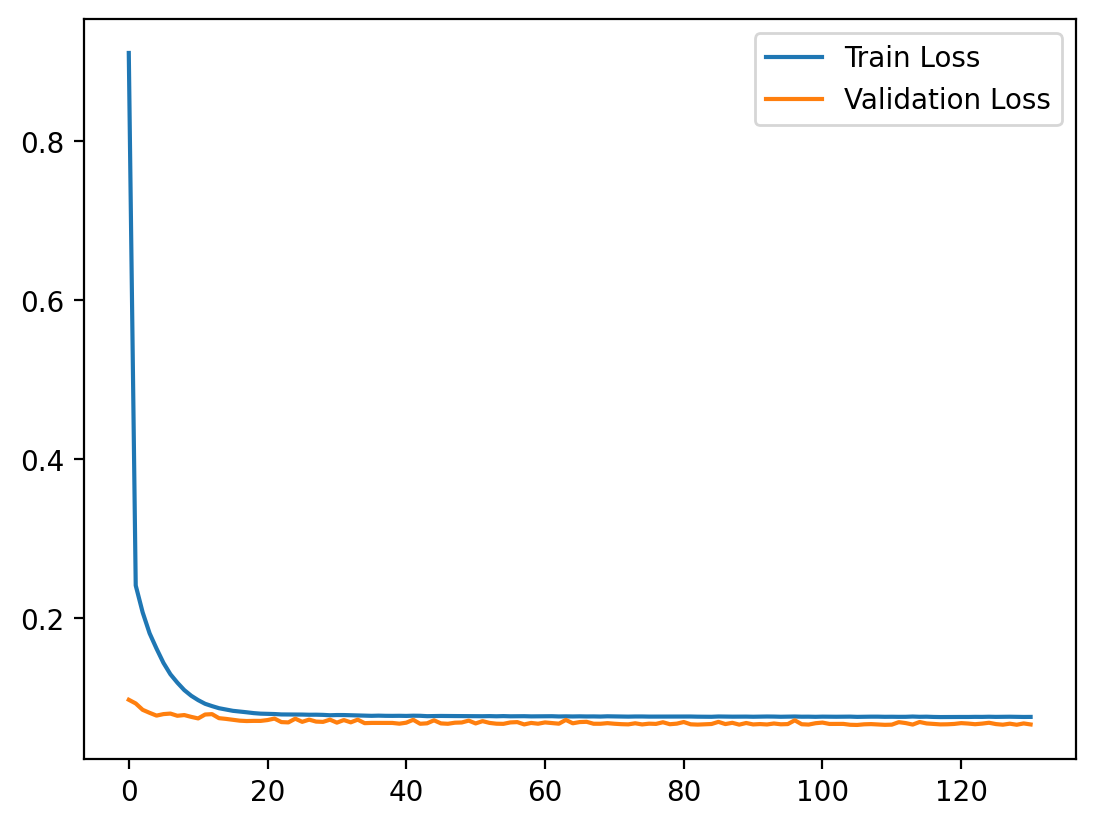

In [ ]:
with open("logs/mlp_256.json", "r") as f:
  mlp_256_hist = json.loads(f.read())

plt.plot(mlp_256_hist["loss"])
plt.plot(mlp_256_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.2 MLP 128x64x32

This creates and compiles a Multilayer Perceptron (MLP) model with three hidden layers.

It creates an instance of the Sequential class, representing a linear stack of layers in the neural network.

Also, it adds an input layer to the network with a shape of (14,), indicating that each input sample has 14 features.

This adds a fully connected layer (Dense) with 128 units and ReLU activation function. The Dropout layer is then added with a dropout rate of 0.2, which helps prevent overfitting by randomly setting 20% of the input units to 0 during training.

This add another fully connected layer with 64 units and ReLU activation function, followed by another Dropout layer with the same dropout rate.

Similarly, these lines add a third fully connected layer with 32 units and ReLU activation function, along with a Dropout layer.

Finally, this adds a final fully connected layer with a single unit, which is typical for regression tasks where the goal is to predict a continuous value.

Here, an instance of the Adam optimizer is created with a learning rate of 0.001. The mean squared error (mean_squared_error) loss function is specified, which is often used for regression problems. The compile method configures the model for training by specifying the loss function and optimizer.

We would have a compiled MLP model named mlp_128_64_32 ready for training or evaluation.

In [ ]:
mlp_128_64_32 = Sequential()

mlp_128_64_32.add(Input(shape=(14,)))

mlp_128_64_32.add(Dense(128, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(64, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(32, activation="relu"))
mlp_128_64_32.add(Dropout(0.2))

mlp_128_64_32.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_128_64_32.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_128_64_32_hist = mlp_128_64_32.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_128_64_32.save("artifacts/mlp_128_64_32.h5")

# with open('logs/mlp_128_64_32.json', "w") as f:
#     f.write(json.dumps(mlp_128_64_32_hist.history))

In [ ]:
mlp_128_64_32 = keras.models.load_model("artifacts/mlp_128_64_32.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_128_64_32)

nn_val_scores["MLP 128x64x32"] = val_mse
nn_test_scores["MLP 128x64x32"] = test_mse
nn_test_scores_actual["MLP 128x64x32"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


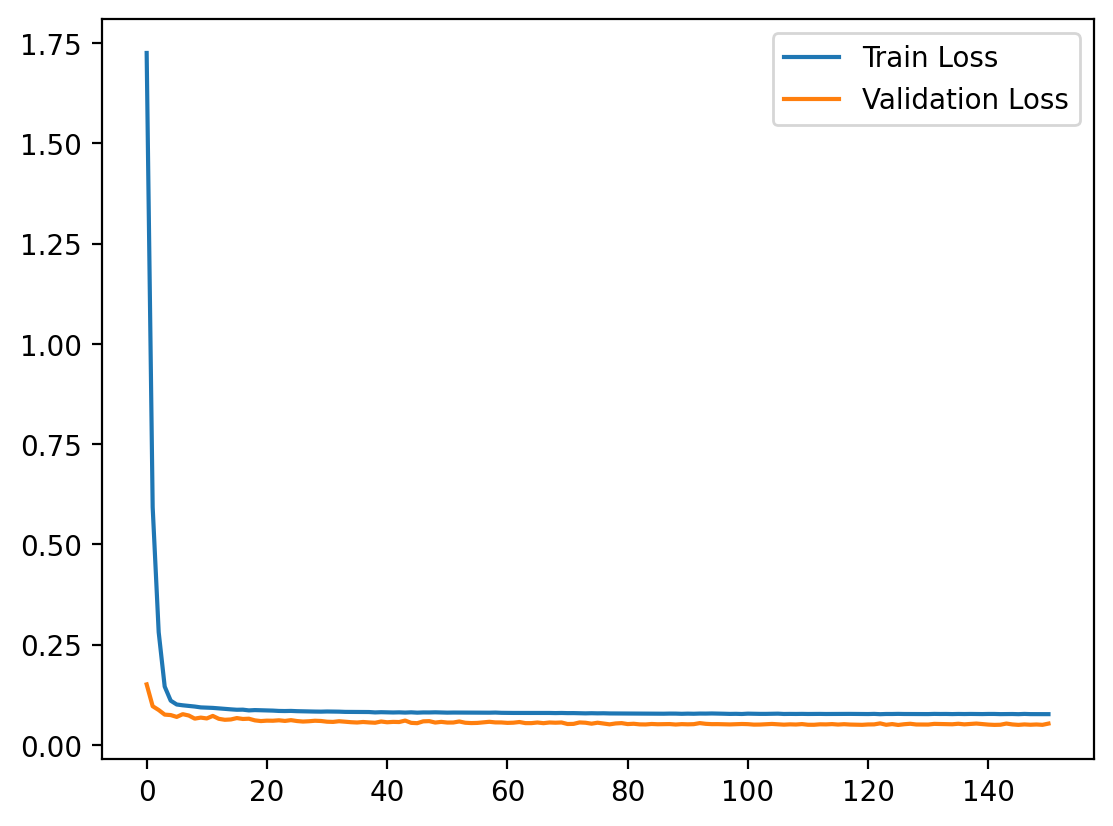

In [ ]:
with open("logs/mlp_128_64_32.json", "r") as f:
  mlp_128_64_32_hist = json.loads(f.read())

plt.plot(mlp_128_64_32_hist["loss"])
plt.plot(mlp_128_64_32_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.3 MLP 256x128x64

In [ ]:
mlp_256_128_64 = Sequential()

mlp_256_128_64.add(Input(shape=(14,)))

mlp_256_128_64.add(Dense(256, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(128, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(64, activation="relu"))
mlp_256_128_64.add(Dropout(0.2))

mlp_256_128_64.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_256_128_64.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_256_128_64_hist = mlp_256_128_64.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_256_128_64.save("artifacts/mlp_256_128_64.h5")

# with open('logs/mlp_256_128_64.json', "w") as f:
#     f.write(json.dumps(mlp_256_128_64_hist.history))

In [ ]:
mlp_256_128_64 = keras.models.load_model("artifacts/mlp_256_128_64.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_256_128_64)

nn_val_scores["MLP 256x128x64"] = val_mse
nn_test_scores["MLP 256x128x64"] = test_mse
nn_test_scores_actual["MLP 256x128x64"] = actual_scores

2346/2346 [==============================] - 3s 1ms/step


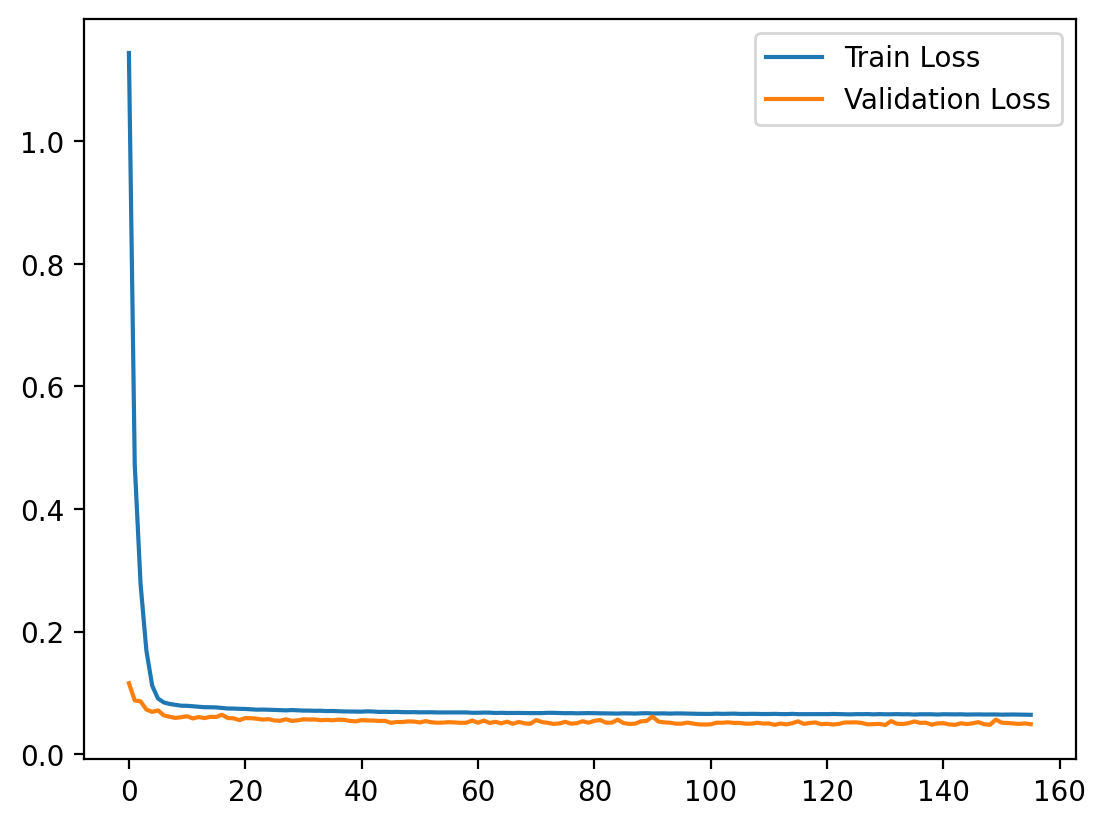

In [ ]:
with open("logs/mlp_256_128_64.json", "r") as f:
  mlp_256_128_64_hist = json.loads(f.read())

plt.plot(mlp_256_128_64_hist["loss"])
plt.plot(mlp_256_128_64_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.4 MLP 1024x512x256

In [ ]:
mlp_1024_512_256 = Sequential()

mlp_1024_512_256.add(Input(shape=(14,)))

mlp_1024_512_256.add(Dense(1024, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(512, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(256, activation="relu"))
mlp_1024_512_256.add(Dropout(0.2))

mlp_1024_512_256.add(Dense(1))

opt = Adam(learning_rate=0.001)
mlp_1024_512_256.compile(loss="mean_squared_error", optimizer=opt)

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)

# mlp_1024_512_256_hist = mlp_1024_512_256.fit(
#   X_train_scaled,
#   y_train_scaled,
#   validation_data=(X_val_scaled, y_val_scaled),
#   epochs=10000,
#   batch_size=32,
#   callbacks=[es]
# )

# mlp_1024_512_256.save("artifacts/mlp_1024_512_256.h5")

# with open('logs/mlp_1024_512_256.json', "w") as f:
#     f.write(json.dumps(mlp_1024_512_256_hist.history))

In [ ]:
mlp_1024_512_256 = keras.models.load_model("artifacts/mlp_1024_512_256.h5")

val_mse, test_mse, actual_scores = evaluate(mlp_1024_512_256)

nn_val_scores["MLP 1024x512x256"] = val_mse
nn_test_scores["MLP 1024x512x256"] = test_mse
nn_test_scores_actual["MLP 1024x512x256"] = actual_scores

2346/2346 [==============================] - 7s 3ms/step


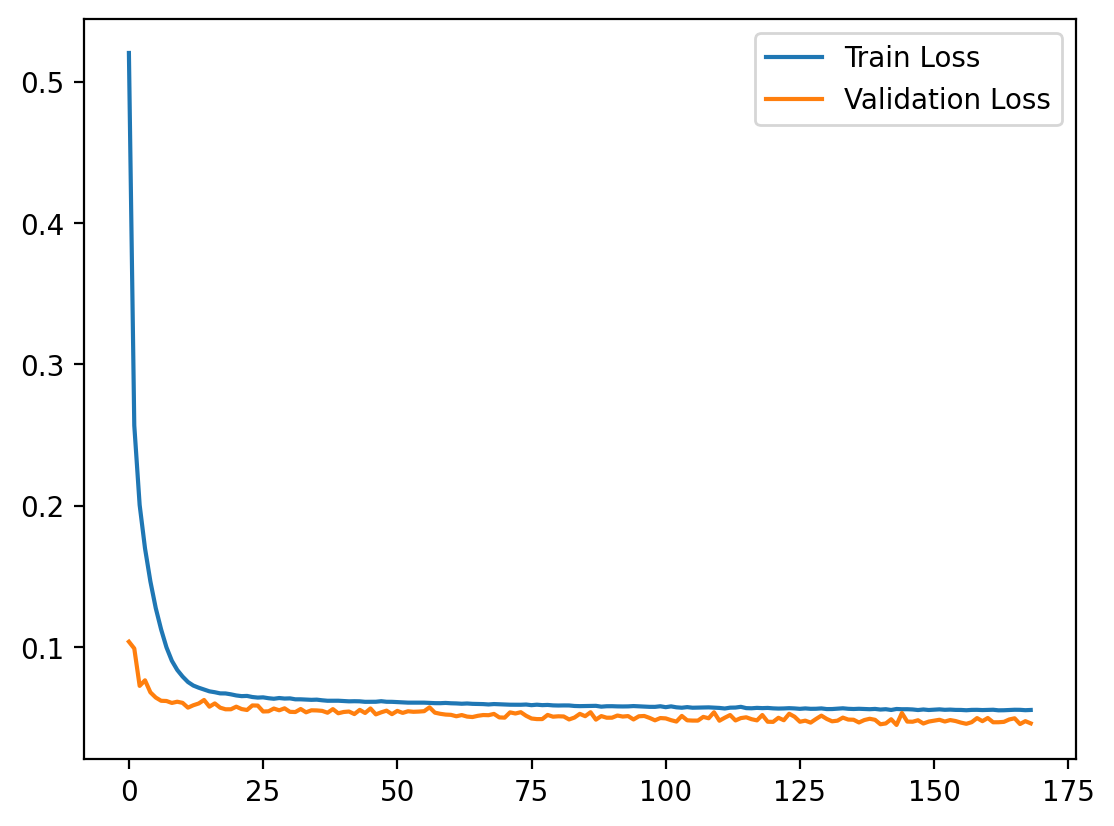

In [ ]:
with open("logs/mlp_1024_512_256.json", "r") as f:
  mlp_1024_512_256_hist = json.loads(f.read())

plt.plot(mlp_1024_512_256_hist["loss"])
plt.plot(mlp_1024_512_256_hist["val_loss"])

plt.legend(["Train Loss", "Validation Loss"])

plt.show()

### 5.3.5 Summary

This code snippet creates a pandas DataFrame from the nn_val_scores and nn_test_scores dictionaries, and then plots a bar chart using the DataFrame.

A pandas DataFrame is created using the pd.DataFrame() constructor. The data for the DataFrame is provided as a dictionary where the keys represent the index labels, and the values are extracted from the nn_val_scores and nn_test_scores dictionaries. The column names are set as "Val MSE" and "Test MSE" to represent the validation and test mean squared error (MSE) scores, respectively.

The line creates a bar plot using the plot.bar() function of the DataFrame nn_val_scores_df. The resulting plot is assigned to the ax variable.

The loop iterates over the individual bars of the bar plot (ax.patches) and adds annotations to each bar. The annotations display the numerical values rounded to four decimal places. The x and y coordinates are adjusted to position the annotations properly.

We display the plot using plt.show() from Matplotlib

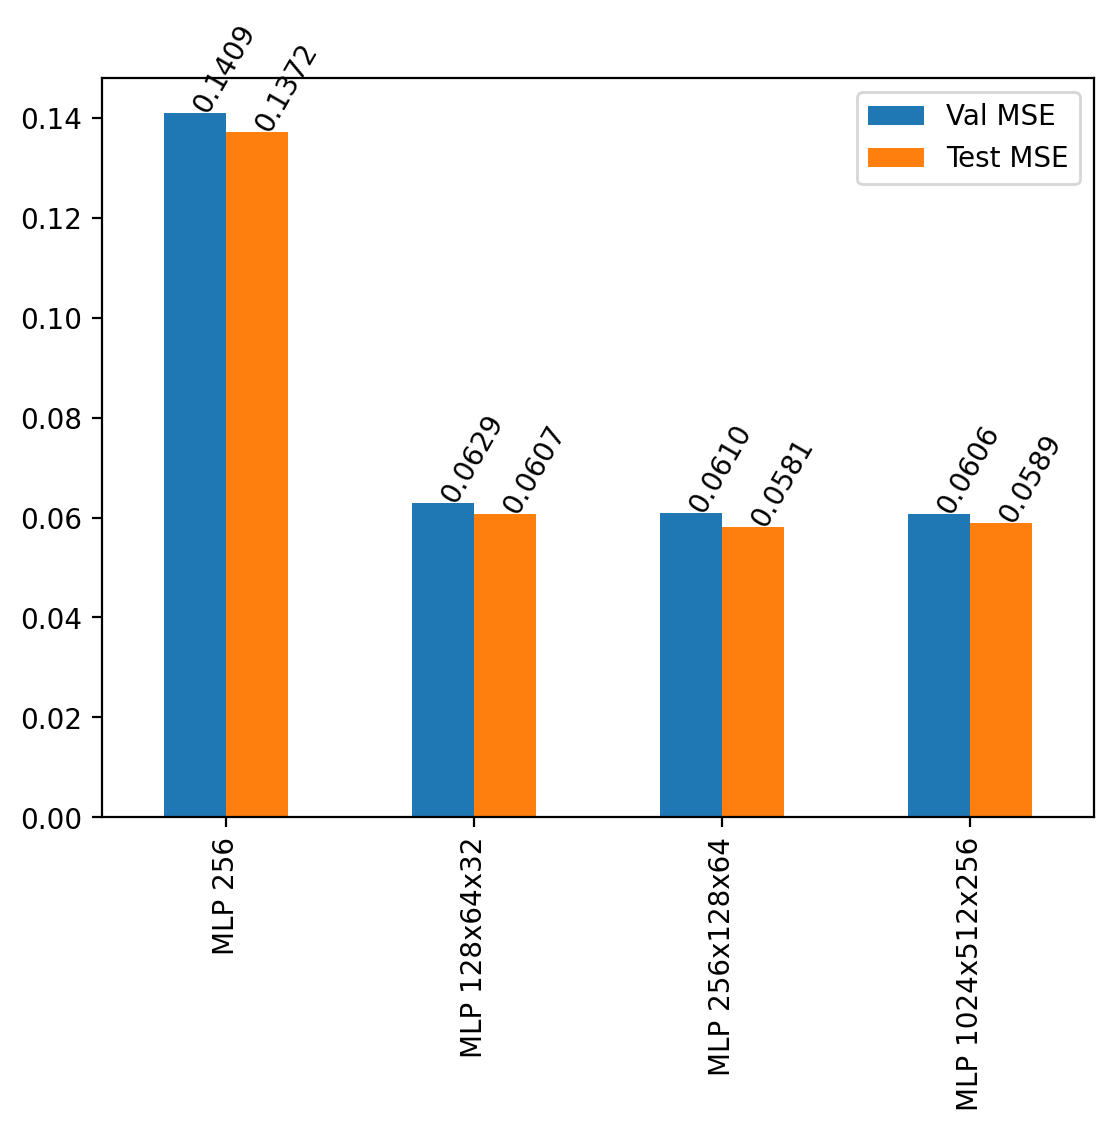

In [ ]:
nn_val_scores_df = pd.DataFrame(
  {
    "Val MSE": nn_val_scores.values(),
    "Test MSE": nn_test_scores.values()
  },
  index=nn_val_scores.keys()
)

ax = nn_val_scores_df.plot.bar()

for p in ax.patches:
    x = p.get_x() + 0.1
    y = p.get_height() + 0.00025
    label = f"{np.round(p.get_height(), 4):.4f}"

    ax.annotate(label, (x, y), ha='left', rotation=60)

plt.show()

This creates a pandas DataFrame from the nn_test_scores_actual dictionary, transposes it, sorts the DataFrame by the "R2" column in descending order, and displays the sorted DataFrame.

This creates a DataFrame using the pd.DataFrame() constructor, where the data is taken from the nn_test_scores_actual dictionary. The .T attribute transposes the DataFrame so that the different model names become the row index.

The .sort_values() method is then called on the DataFrame to sort it based on the values in the "R2" column. The by parameter specifies the column to sort by, and ascending=False ensures the sorting is done in descending order.

The resulting DataFrame will display the model names as the row index and the corresponding evaluation scores, including the "R2" column, sorted in descending order of the "R2" values.

In [ ]:
pd.DataFrame(nn_test_scores_actual).T.sort_values(by="R2", ascending=False)

,MAE,MAPE,MSE,RMSE,R2
MLP 256x128x64,2668.290067,0.167794,2.264672e+07,4758.857342,0.956096
MLP 128x64x32,2727.796221,0.174643,2.304899e+07,4800.936074,0.955316
MLP 1024x512x256,2730.712161,0.170084,2.415299e+07,4914.569060,0.953176
MLP 256,3157.997037,0.222839,2.779150e+07,5271.764813,0.946122


# 6. Evaluation

This code section applies the inverse transformation to the predictions made by a LightGBM model and creates a pandas Series from the predictions.

In this line, the predict() method of the LightGBM model (lgb) is called on the scaled test data (X_test_scaled). The np.expm1() function is applied to the predictions to reverse the logarithmic transformation commonly used for target variables. This is often done when the target variable represents prices or counts, as the np.expm1() function calculates exp(x) - 1, providing the inverse of np.log1p().

This creates a pandas Series (y_pred_series) from the y_pred array, using the test data index (X_test.index) as the index for the Series. The name parameter is set to "predicted_price" to give a name to the Series.

We will have a pandas Series (y_pred_series) containing the predictions made by the LightGBM model, with the corresponding index matching the test data.

In [ ]:
y_pred = np.expm1(lgb.predict(X_test_scaled))
y_pred_series = pd.Series(y_pred, index=X_test.index, name="predicted_price")

This concatenates the test features, actual target values (y_test), predicted target values (y_pred_series), and calculates the deviation between the predicted and actual target values.

This concatenates the test features (X_test), actual target values (y_test), and predicted target values (y_pred_series) along the column axis (axis=1). The resulting DataFrame (predicted_df) will have the test features, actual target values, and predicted target values as columns.

This calculates the deviation between the predicted target values and the actual target values. It subtracts the "price" column (actual target values) from the "predicted_price" column (predicted target values) and assigns the result to a new column named "deviation" in the predicted_df DataFrame.

This selects a subset of columns from the predicted_df DataFrame, including the categorical features, numerical features, "price" (actual target values), and "predicted_price" (predicted target values). The .head() method is then called to display the first few rows of the resulting DataFrame.

We will have a DataFrame (predicted_df) that includes the test features, actual target values, predicted target values, and the deviation between the predicted and actual target values. The displayed subset of columns will include the specified categorical and numerical features, as well as the "price" and "predicted_price" columns.

In [ ]:
predicted_df = pd.concat([X_test, y_test, y_pred_series], axis=1)
predicted_df["deviation"] = predicted_df["predicted_price"] - predicted_df["price"]
predicted_df[categorical_features + numerical_features + ["price", "predicted_price"]].head()

,date,airline,flight,source_city,destination_city,stops,via,class,days_left,departure_time_hr,departure_time_min,arrival_time_hr,arrival_time_min,duration,price,predicted_price
80343,2022-03-05,Indigo,UK-825,Mumbai,Chennai,1-stop,UNK,Economy,23,16,55,21,40,285.0,6556,6862.892830
54405,2022-02-21,Air India,AI-864,Mumbai,Bangalore,1-stop,IXU,Economy,11,15,35,8,55,1040.0,9201,9145.679063
193431,2022-03-27,Vistara,UK-832,Chennai,Mumbai,1-stop,UNK,Economy,45,7,5,17,40,635.0,4637,4831.069302
108624,2022-03-24,Air India,G8-395,Bangalore,Kolkata,1-stop,UNK,Economy,42,6,10,14,30,500.0,6583,6700.177533
35005,2022-03-29,Vistara,UK-981,Delhi,Hyderabad,1-stop,UNK,Economy,47,20,40,12,15,935.0,5549,5514.430048


This calculates the mean prices for actual and predicted values grouped by the number of days left, and then plots a line chart comparing the actual and predicted prices.

This creates a new DataFrame (prices_by_days_left) by selecting the columns "days_left", "price", and "predicted_price" from the predicted_df DataFrame. It then groups the data by the "days_left" column and calculates the mean of the "price" and "predicted_price" columns for each group.

We plot the actual and predicted prices against the index values (which correspond to the unique values in the "days_left" column). The plt.plot() function is used to create the line plot.

We add labels to the x-axis and y-axis of the plot using plt.xlabel() and plt.ylabel(), respectively. The plt.legend() function is used to create a legend for the plot, specifying the labels for the actual and predicted prices.

We display the plot using plt.show() from Matplotlib.

We will have a line chart showing the trend of the actual and predicted prices over the number of days left. The x-axis represents the days left, the y-axis represents the price in INR, and the legend indicates the lines representing the actual and predicted prices.

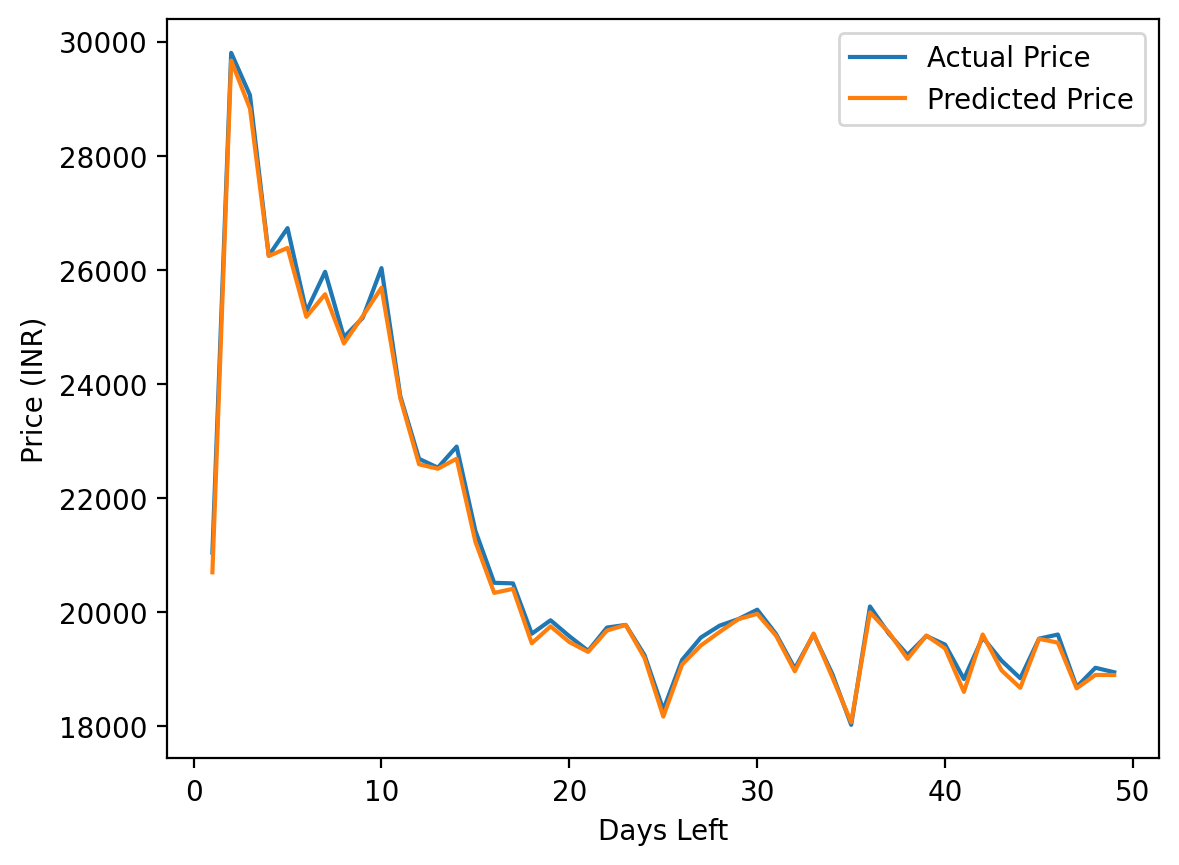

In [ ]:
prices_by_days_left = predicted_df[["days_left", "price", "predicted_price"]].groupby("days_left").mean()

plt.plot(prices_by_days_left.index, prices_by_days_left["price"])
plt.plot(prices_by_days_left.index, prices_by_days_left["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

This calculates the mean prices for actual and predicted values grouped by both the "class" and "days_left" columns. Then, it plots two line charts side by side, each representing the actual and predicted prices for a different class ("Business" and "Economy").

This creates a new DataFrame (prices_by_days_left) by selecting the columns "class", "days_left", "price", and "predicted_price" from the predicted_df DataFrame. It then groups the data by both the "class" and "days_left" columns and calculates the mean of the "price" and "predicted_price" columns for each group.

We create a figure with a size of 9.6 inches by 4.8 inches using plt.figure(figsize=(9.6, 4.8)). The figure is divided into two subplots using plt.subplot(1, 2, 1) and plt.subplot(1, 2, 2).

In the first subplot (plt.subplot(1, 2, 1)), the actual and predicted prices for the "Business" class are plotted using plt.plot(). The x-axis represents the index values (which correspond to the unique values in the "days_left" column), and the y-axis represents the price in INR. The x-axis label is set to "Days Left" using plt.xlabel(), and a legend is added using plt.legend().

In the second subplot (plt.subplot(1, 2, 2)), the actual and predicted prices for the "Economy" class are plotted using plt.plot(). Similarly, the x-axis label and legend are added.

Finally, plt.show() is called to display the figure with the two subplots.

We will have a figure with two line charts side by side. Each chart represents the trend of the actual and predicted prices over the number of days left for a specific class ("Business" and "Economy").

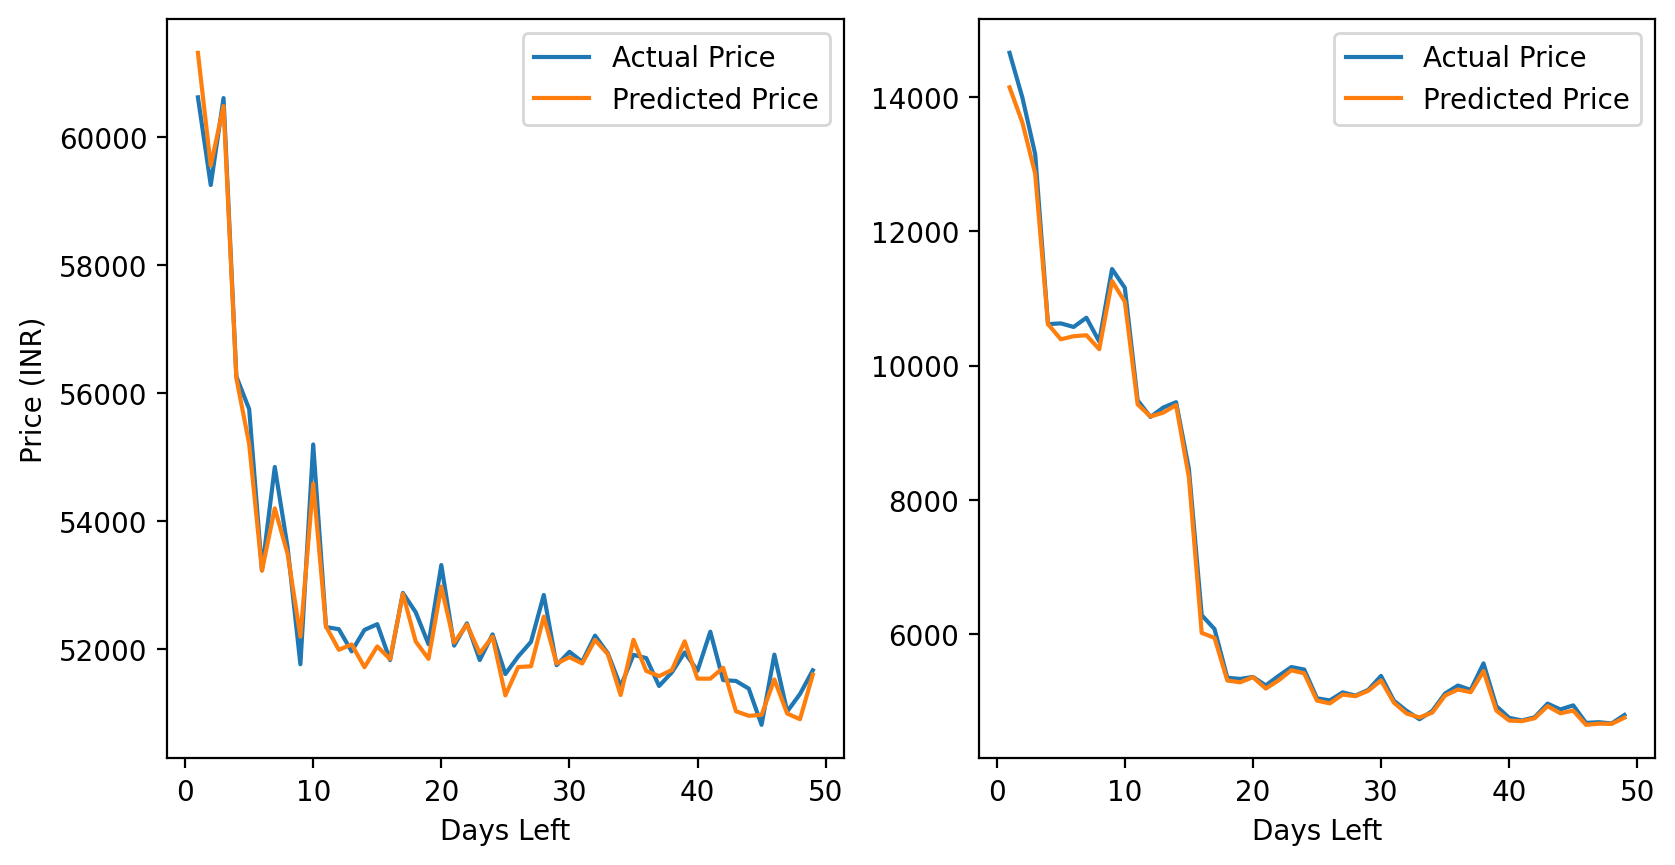

In [ ]:
prices_by_days_left = predicted_df[["class", "days_left", "price", "predicted_price"]].groupby(["class", "days_left"]).mean()

plt.figure(figsize=(9.6, 4.8))
plt.subplot(1, 2, 1)
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["price"])
plt.plot(prices_by_days_left.loc["Business"].index, prices_by_days_left.loc["Business"]["predicted_price"])

plt.xlabel("Days Left")
plt.ylabel("Price (INR)")
plt.legend(["Actual Price", "Predicted Price"])

plt.subplot(1, 2, 2)
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["price"])
plt.plot(prices_by_days_left.loc["Economy"].index, prices_by_days_left.loc["Economy"]["predicted_price"])

plt.xlabel("Days Left")
plt.legend(["Actual Price", "Predicted Price"])

plt.show()

## 6.1 Error Distribution

The predicted_df["deviation"].describe() calculates descriptive statistics for the "deviation" column in the predicted_df DataFrame.

This accesses the "deviation" column of the predicted_df DataFrame using square brackets ([]). The .describe() method is then applied to the "deviation" column, which generates various summary statistics for the column, including count, mean, standard deviation, minimum value, 25th percentile, median (50th percentile), 75th percentile, and maximum value.

We will see the summary statistics for the "deviation" column of the predicted_df DataFrame.

In [ ]:
predicted_df["deviation"].describe()

count    75065.000000
mean       -95.526713
std       2335.634193
min     -46240.171834
25%       -310.070898
50%         28.512679
75%        448.412478
max      26699.322927
Name: deviation, dtype: float64

This calculates specific quantiles (percentiles) for the "deviation" column in the predicted_df DataFrame.

The lines access the "deviation" column of the predicted_df DataFrame using square brackets ([]). The .quantile() method is then applied to the "deviation" column with different quantile values (0.9, 0.95, and 0.99).

The quantile() method calculates the value at the specified quantile for the column. For example, predicted_df["deviation"].quantile(0.9) will return the value at the 90th percentile of the "deviation" column.

By printing these values, we can assess the distribution of deviations and understand the range within which a certain percentage of predictions fall.

We will see the specific quantile values (percentiles) for the "deviation" column of the predicted_df DataFrame.

In [ ]:
print(predicted_df["deviation"].quantile(0.9))
print(predicted_df["deviation"].quantile(0.95))
print(predicted_df["deviation"].quantile(0.99))

1494.142427456703
2555.6950093629525
5771.390596539611


The predicted_df[["class", "deviation"]].groupby("class").describe() calculates descriptive statistics for the "deviation" column in the predicted_df DataFrame, grouped by the "class" column.

We create a new DataFrame by selecting the columns "class" and "deviation" from the predicted_df DataFrame using double square brackets ([["class", "deviation"]]). It then groups the data by the "class" column using the .groupby() method. Finally, the .describe() method is applied to the grouped data, which generates descriptive statistics for the "deviation" column within each group (class).

We will see the descriptive statistics (count, mean, standard deviation, minimum value, 25th percentile, median (50th percentile), 75th percentile, and maximum value) for the "deviation" column, grouped by the "class" column in the predicted_df DataFrame.



In [ ]:
predicted_df[["class", "deviation"]].groupby("class").describe()

deviation                                                       
             count        mean          std           min          25%   
class                                                                    
Business   23348.0 -141.880800  3819.767817 -46240.171834 -1046.281135  \
Economy    51717.0  -74.599838  1153.136516 -18388.858739  -186.817769   

                                                 
                 50%          75%           max  
class                                            
Business  235.994509  1532.029274  26699.322927  
Economy    16.933275   248.300237  13020.889538

To calculate specific quantiles (percentiles) for the "deviation" column in the predicted_df DataFrame, grouped by the "class" column, we use the .quantile() method with the groupby() function.

These group the data in the predicted_df DataFrame by the "class" column using the groupby() function. Then, for each group, the .quantile() method is applied specifically to the "deviation" column.

By specifying the quantile value (0.9, 0.95, 0.99), we can calculate the respective quantile for each group.

We will see the specific quantile values (percentiles) for the "deviation" column, grouped by the "class" column in the predicted_df DataFrame.

In [ ]:
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.9))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.95))
print(predicted_df[["class", "deviation"]].groupby("class").quantile(0.99))

            deviation
class                
Business  3214.396975
Economy    680.270402
            deviation
class                
Business  4677.013117
Economy   1103.524758
            deviation
class                
Business  8532.653368
Economy   2467.626997


# 7. Deployment

# 8. Conclusion